In [1]:
import glob
import re
from collections import OrderedDict

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
from nilearn import masking, plotting
from scipy.stats import spearmanr


## The functions you wrote for the analysis

In [2]:
def create_fmri_dict(sub_ids, complete_data, mask_data, n_voxels):
    data_dict = OrderedDict()
    for sub_id in sub_ids:
        subject_array = np.zeros((40, n_voxels))
        sub_data = sorted([file for file in complete_data if sub_id in file])
        for i in range(40):
            img = nib.load(sub_data[i])
            data = img.get_fdata()
            masked_values = data[mask_data]
            subject_array[i, :] = masked_values
        data_dict[sub_id] = subject_array
    return data_dict


def get_sub_event_file(sub_id, events_files):
    for file in events_files:
        if sub_id in file:
            return file


def create_behav_dict(sub_ids, events_files):
    behav_dict = {}
    for sub_id in sub_ids:
        behav_vector = []
        sub_event_file = get_sub_event_file(sub_id, events_files)
        df = pd.read_csv(sub_event_file, sep='\t')
        # create behav_vector, making sure the responses are in order from Q01-40
        for i in range(40):
            str_question_num = 'Q' + str(i + 1).zfill(2)
            response = df.loc[df['trial_type'] == str_question_num, 'coded_response']
            behavior = response.values[0]
            behav_vector.append(behavior)
        behav_dict[sub_id] = np.array(behav_vector)
    return behav_dict


# Step 1: Make a mask

Your code did do exactly what I suggested, so that's great!  Once you get the code to work see if you can ask further questions about whether it is doing exactly what we'd like.  My instructions won't always include exact details, since optimal settings may not be known when I'm making the suggestions or I may have missed something.  Definitely always look at brain masks (I made a big error that was driven by skipping this step recently!).  Also, maybe after a break from the code, come back and see if there are settings that could have been changed. When running this I looked at the help from intersect_masks and realized it had a threshold option, which defaults to 0.5 when I really wanted the full intersection (threshold=1).  This made me wonder whether that was optimal.  Questions I then asked myself were
* What does the brain mask look like?
    * we should always look and the hope is that it doesn't wander outside of the brain
    * if it cuts off brain we should figure out why (likely a few subjects are missing data)
* Is the threshold=0.5 okay?  If subjects are missing in voxels it seems we shouldn't include that subject OR we should consider using a higher threshold so all subjects we analyze have data for all voxesl in our mask. This analysis requires us to use the same subjects for all voxels, so there will likely be a balance between omitting subjects and having a good mask.

In [3]:
root = '/oak/stanford/groups/russpold/data/uh2/aim1'
lev1_out = (
    f'{root}/derivatives/output_surveyMedley_noderivs_factors/surveyMedley_lev1_output'
    f'/task_surveyMedley_rtmodel_rt_uncentered'
)
bold_files = sorted(glob.glob(f'{lev1_out}/contrast_estimates/*Q*'))

# Step 1: Make a group mask
subject_masks = glob.glob(
    f'{root}/derivatives/fmriprep/sub-s*/ses-['
    f'0-9]/func/*surveyMedley*space-MNI152NLin2009cAsym*mask*.nii.gz'
)
# some of the subject masks are of subjects excluded from all analysis, so remove these masks
excluded_subjects_csv = pd.read_csv(f'{lev1_out}/excluded_subject.csv')
excluded_subjects_column = excluded_subjects_csv['subid_task'].tolist()
excluded_subject_ids = set([s[:3] for s in excluded_subjects_column])
subject_masks = [
    mask for mask in subject_masks if not any(id in mask for id in excluded_subject_ids)
]

group_mask = masking.intersect_masks(subject_masks, threshold=0.95)

mask_data = group_mask.get_fdata().astype(bool)
n_voxels = np.sum(mask_data)


In [4]:
print('Number of subjects used in group mask')
print(len(subject_masks))
print(f'There are {n_voxels} voxels in the group brain mask')

Number of subjects used in group mask
95
There are 167672 voxels in the group brain mask


### Exploring different threshold cutoffs
By looking at the group mask and looking closer at the options for intersect_mask, I realized it was letting in voxels that didn't have complete data that wandered a bit outside of the brain. Technically, I'd like to use a threshold of 1, but that ended up removing a bit of the front of the brain (see below).  I tried different thresholds in an effort to figure out how many subjects were contributing to the loss (I could have also made a sum image and plotted that).

Below you'll see I figure out which subjects are contributing to the shrinking of the mask in the front of the brain.

In [5]:
mask_thresholds = [0.5, 0.8, 0.9, 0.95, 0.99, 1]

mask_explore = {}

for mask_threshold in mask_thresholds:
    mask_explore[f'Threshold={mask_threshold}'] = masking.intersect_masks(
        subject_masks, threshold=mask_threshold
    )


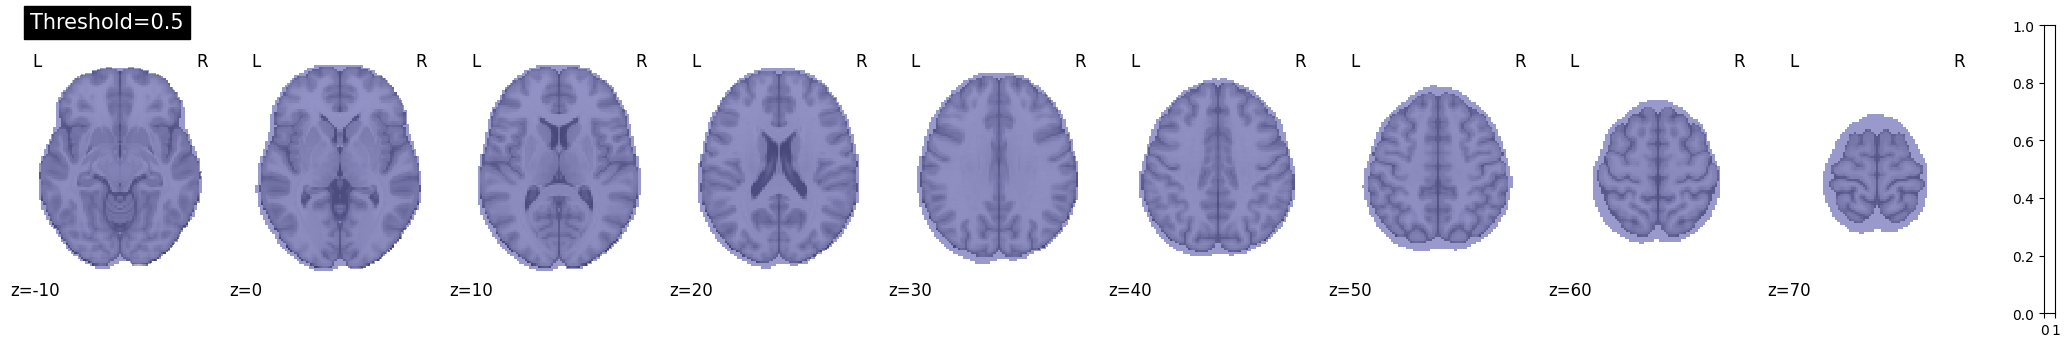

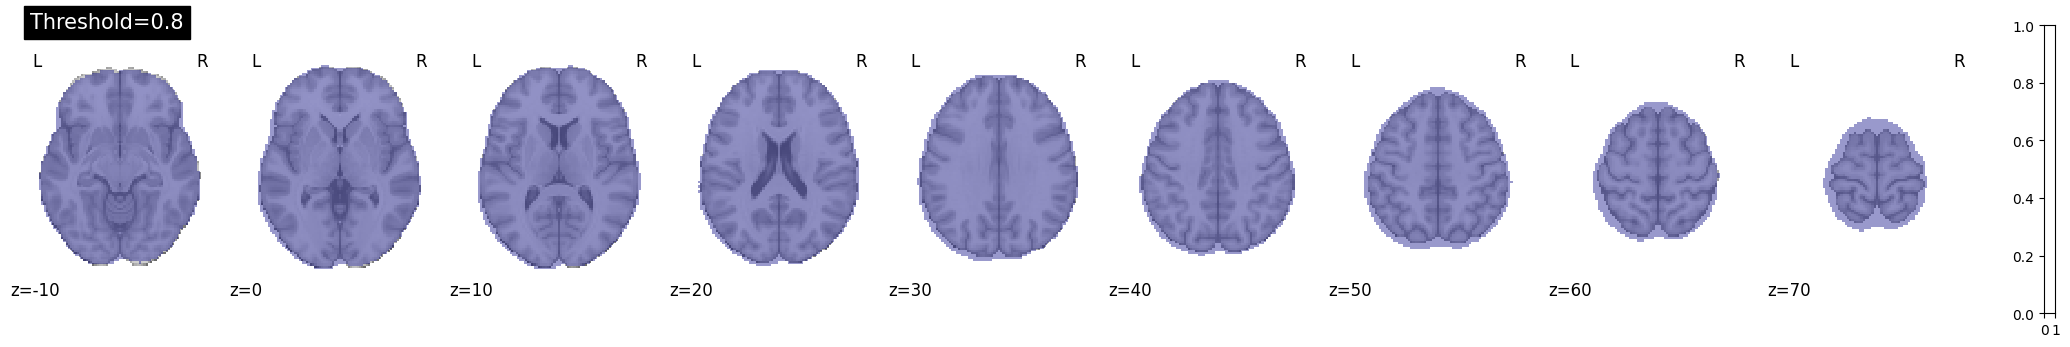

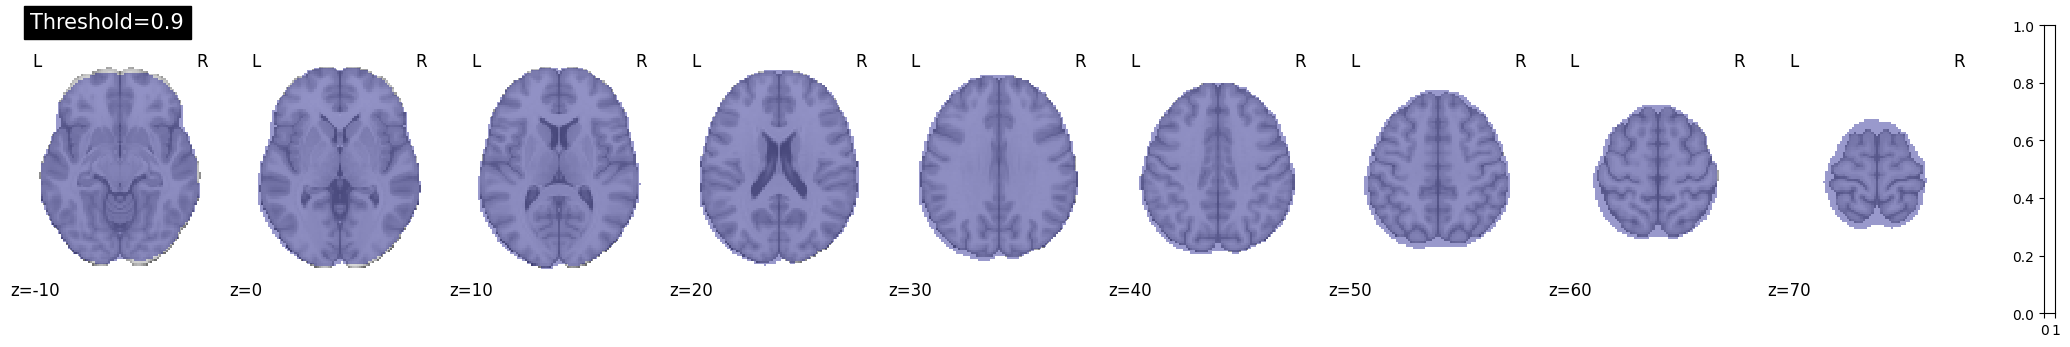

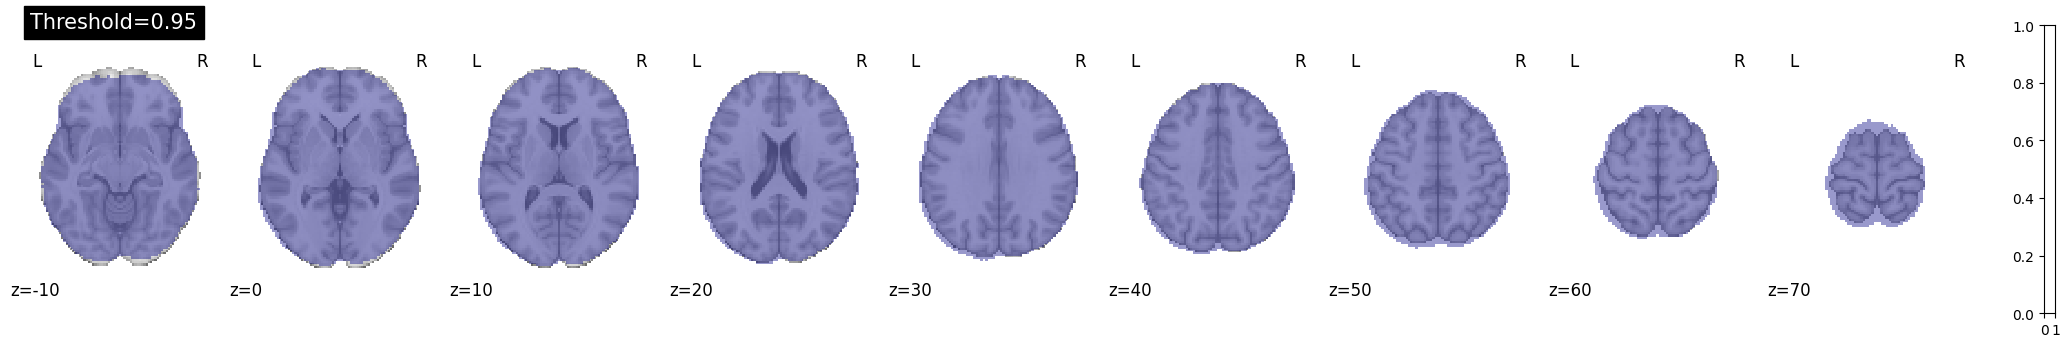

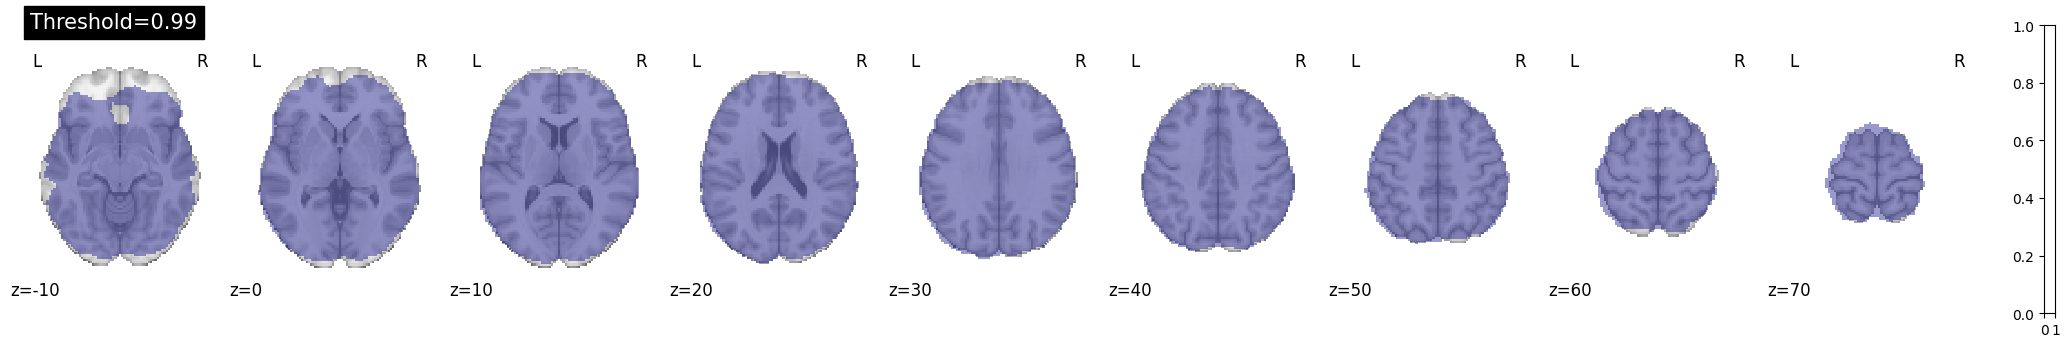

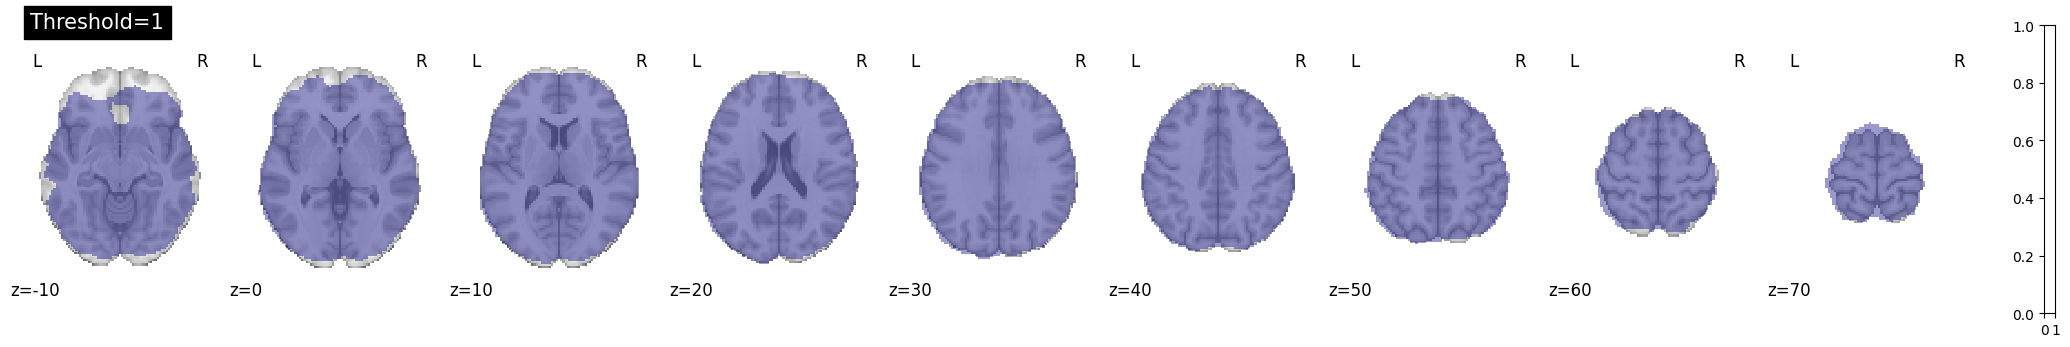

In [6]:
z_slices = list(range(-10, 80, 10))
for key, mask in mask_explore.items():
    plotting.plot_roi(mask, title=key, display_mode='z', cut_coords=z_slices, alpha=0.4)

### Use an interactive brain viewer to locate voxel coordinates (in mm) to see which subjects are missing data

Note, that it is tricky sometimes because coordinates may be displayed in mm (if this happens negative values are possible) or with respect to the location in the matrix (integer values indicating indices in matrix).  Here mm are used and later you'll see a voxel location referring to the data matrix index is used.

/home/users/jmumford/jaemon/.venv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_30400/1930971060.py:2: UserWarning: Casting data from int32 to float32
  plotting.view_img(mask_explore['Threshold=1'])
/tmp/ipykernel_30400/1930971060.py:2: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  plotting.view_img(mask_explore['Threshold=1'])



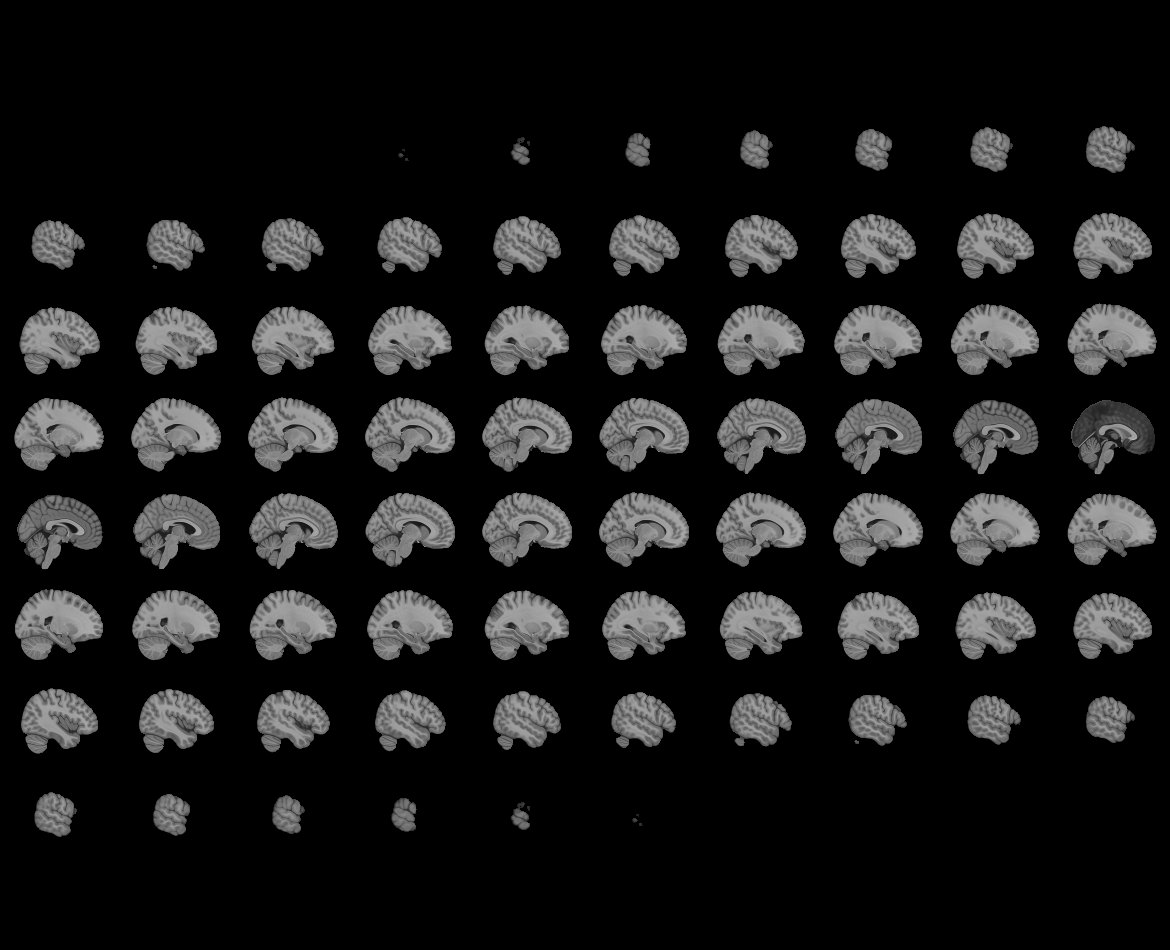
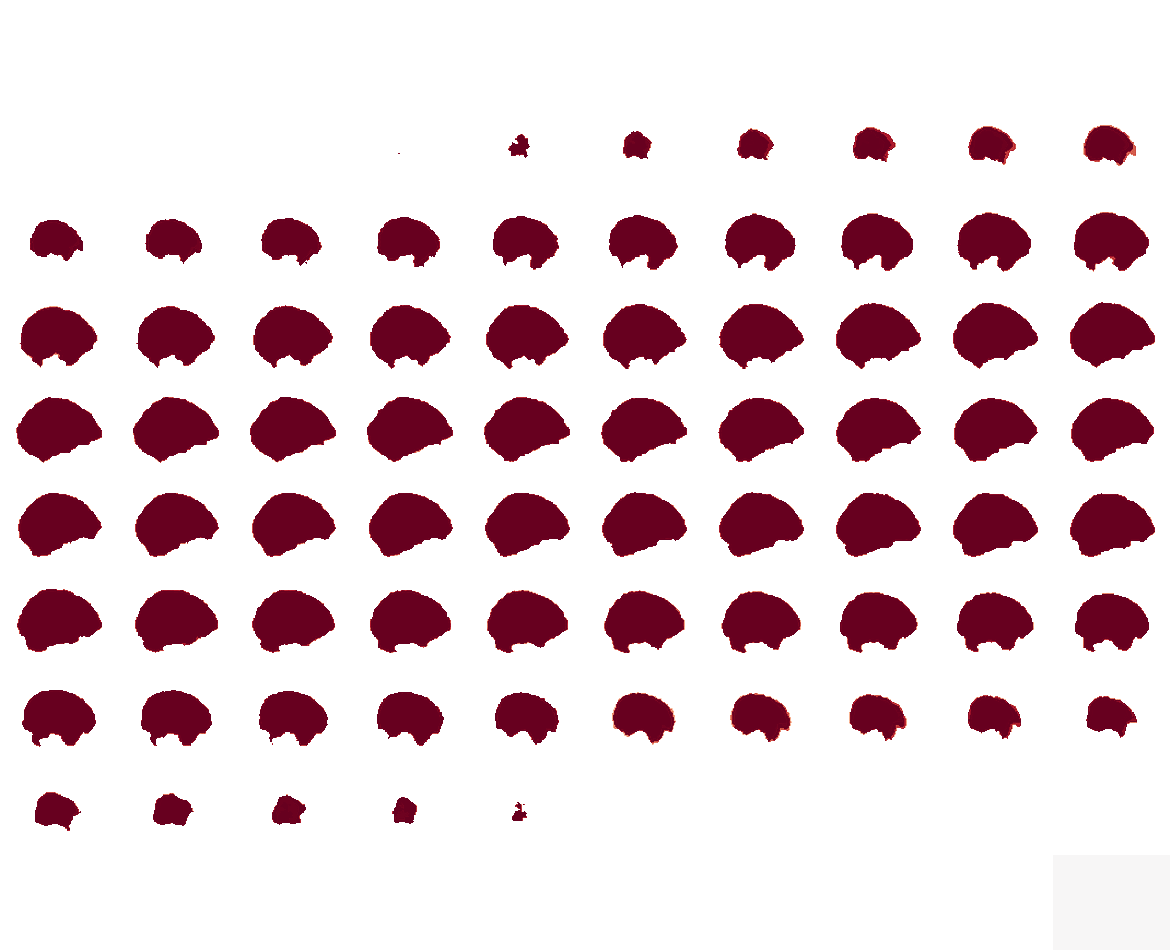

In [7]:
# This gives me an interactive viewer so I can locate a coordinate where the dropout occurs.  Then I can use that to find the subjects who are contributing.
plotting.view_img(mask_explore['Threshold=1'])


### Find the subject(s) contributing to most of the dropout

In [8]:
def find_subjects_with_zero_at_coord_lazy(masks, coord):
    failed_subjects = []

    for path in masks:
        img = nib.load(path)
        affine = img.affine
        voxel_coords = np.round(
            np.linalg.inv(affine).dot(np.append(coord, 1))[:3]
        ).astype(int)

        # Check bounds
        if np.all((0 <= voxel_coords) & (voxel_coords < img.shape)):
            val = img.dataobj[tuple(voxel_coords)]  # Lazy access
            if val == 0:
                failed_subjects.append(path)
        else:
            print(f'Coordinate {voxel_coords} out of bounds for {path}')

    return failed_subjects


In [9]:
coord_check = [-18, 62, -10]  # voxel where dropout occurs

masks_with_dropout = find_subjects_with_zero_at_coord_lazy(subject_masks, coord_check)

In [10]:
masks_with_dropout

['/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/fmriprep/sub-s445/ses-1/func/sub-s445_ses-1_task-surveyMedley_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
 '/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/fmriprep/sub-s234/ses-2/func/sub-s234_ses-2_task-surveyMedley_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz']

In [11]:
sub_ids_dropout = [
    re.search(r'sub-s(\d+)_ses-', path).group(1) for path in masks_with_dropout
]
print(sub_ids_dropout)

['445', '234']


### Refine mask AND note that we need to further investigate subject s234 & s445.  I will omit them from this analysis (if they made it in)

The resulting mask seems decent enough for this analysis.



In [12]:
subject_masks_no_dropout = [
    mask for mask in subject_masks if mask not in masks_with_dropout
]

print(len(subject_masks))
print(len(subject_masks_no_dropout))

95
93


### The compromised between losing subjects and keeping brain voxels
Just a little bit of the front of the brain is omitted here.  Technically this part of the data is typically really noisy and so I don't think it should be that deterimental to our analysis to lose a few of the voxels in this noisy area.

Note, if Patrick really needs these voxels in the front of the brain we can further eliminate subjects to have better coverage, but it is a tradeoff.

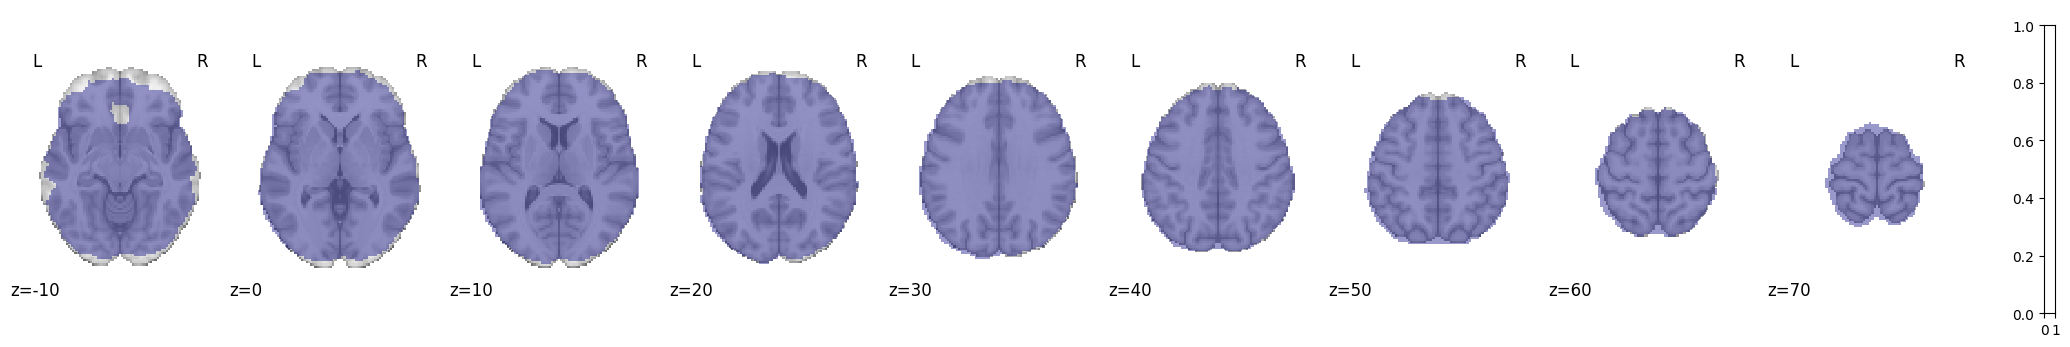

In [13]:
# make final group mask and double check
group_mask = masking.intersect_masks(subject_masks_no_dropout, threshold=1)

plotting.plot_roi(group_mask, display_mode='z', cut_coords=z_slices, alpha=0.4)

# Step 2: Sorted list of subject IDS for subjects who answered all questions
Your code was perfectly fine! Note, I make the additional removal of subject(s) who contribued to that mask dropout, because they will not have data in some of our mask voxels.

In [14]:
# Step 2: Sorted list of subject IDs for subjects who answered all questions
all_sub_ids = set([re.search('_sub_(.*)_rtmodel_', val).group(1) for val in bold_files])
sub_ids = []
for sub in all_sub_ids:
    all_questions_present = True
    for i in range(40):
        str_question_num = 'Q' + str(i + 1).zfill(2)
        if (
            f'{lev1_out}/contrast_estimates/task_surveyMedley_contrast_{str_question_num}_v_baseline_sub_{sub}_rtmodel_rt_uncentered_stat_contrast.nii.gz'
            not in bold_files
        ):
            all_questions_present = False
    if all_questions_present:
        sub_ids.append(sub)
sorted_sub_ids = sorted(sub_ids)


# JM added this: remove 234 and 445 if present (length dropped by 1)
print(len(sorted_sub_ids))
sorted_sub_ids = [subid for subid in sorted_sub_ids if subid not in sub_ids_dropout]
print(len(sorted_sub_ids))

35
34


# Step 3: Load and store the contrast maps

Your code definitely worked, but I've recently discovered that when you have a mask, the most memory efficient way to import the data is to use nifti masker (it doesn't load ALL of the data in and then mask it, but only loads in the data you need).  I typically do use the NiftiMasker, but didn't realize it was more optimal than how you had originally done it until a couple of weeks ago. So, this is news to me too!

Given this, I'm revamping your function (that was above) a little bit. There wasn't anything wrong with your code, but it could be more efficient and a bit less susceptible to silent errors 
* NiftiMasker will be faster
* I'm sure your code was perfectly fine, but it could have broken from relying on sort, so I added some extra security by looking for the question number in the path. 


Note, I tinkered around a little and using concat_imgs to concatenate the images first was most efficient.  ChatGPT didn't come up with that on its first try, so sometimes you need to really push it to do the most efficient thing.  Plus, now we both know NiftiMasker is most efficient and for multiple images, concatenating first is a handy step that is more efficient than masking the individual images and then concatenating!

In [15]:
from nilearn.maskers import NiftiMasker


def create_fmri_dict_mem_eff(sub_ids, complete_data, group_mask_img):
    """
    Create a memory-efficient dictionary of fMRI data using NiftiMasker.
    Files are matched explicitly by Q01–Q40 substrings to ensure order.

    Parameters
    ----------
    sub_ids : list of str
        Subject IDs to extract from complete_data.
    complete_data : list of str
        List of file paths to 3D fMRI NIfTI images.
    group_mask_img : nibabel.Nifti1Image
        Mask image already loaded into memory.

    Returns
    -------
    data_dict : OrderedDict
        Dictionary where keys are subject IDs and values are (40, n_voxels) arrays.
    """
    masker = NiftiMasker(mask_img=group_mask_img)
    data_dict = OrderedDict()

    for sub_id in sub_ids:
        # Select files for this subject
        sub_files = [f for f in complete_data if sub_id in f]

        # Ensure 1 file for each Q01–Q40
        ordered_paths = []
        for q in range(1, 41):
            qstr = f'Q{q:02d}'
            matches = [f for f in sub_files if qstr in f]
            if len(matches) != 1:
                raise ValueError(
                    f'Expected one match for {qstr} in subject {sub_id}, found {len(matches)}'
                )
            ordered_paths.append(matches[0])

        # Load and mask
        imgs = [nib.load(p) for p in ordered_paths]
        stacked_img = nib.concat_images(imgs)
        masked_data = masker.fit_transform(stacked_img)  # shape: (40, n_voxels)

        data_dict[sub_id] = masked_data

    return data_dict

In [16]:
complete_data = sorted(
    [file for file in bold_files if any(sub_id in file for sub_id in sorted_sub_ids)]
)
fmri_data_dict = create_fmri_dict_mem_eff(sorted_sub_ids, complete_data, group_mask)

In [17]:
# Check dimensions
print(f'There are {len(fmri_data_dict)} subjects')

for key, value in fmri_data_dict.items():
    print(f'For subject {key} data dim is {value.shape}')

There are 34 subjects
For subject 130 data dim is (40, 153007)
For subject 172 data dim is (40, 153007)
For subject 192 data dim is (40, 153007)
For subject 465 data dim is (40, 153007)
For subject 518 data dim is (40, 153007)
For subject 519 data dim is (40, 153007)
For subject 524 data dim is (40, 153007)
For subject 526 data dim is (40, 153007)
For subject 548 data dim is (40, 153007)
For subject 554 data dim is (40, 153007)
For subject 555 data dim is (40, 153007)
For subject 557 data dim is (40, 153007)
For subject 570 data dim is (40, 153007)
For subject 572 data dim is (40, 153007)
For subject 574 data dim is (40, 153007)
For subject 582 data dim is (40, 153007)
For subject 583 data dim is (40, 153007)
For subject 584 data dim is (40, 153007)
For subject 587 data dim is (40, 153007)
For subject 589 data dim is (40, 153007)
For subject 590 data dim is (40, 153007)
For subject 593 data dim is (40, 153007)
For subject 594 data dim is (40, 153007)
For subject 595 data dim is (40, 15

# Step 4: Estimate behavioral distance

Like everywhere else, the code here was fine, I just added a couple of figures to understand the distribution of the behavioral distance measures.

In [18]:
# initially I worried about how you read in the file paths, but I see your function nicely keeps the subjects ordered correctly.
events_files = sorted(
    glob.glob(f'{root}/BIDS/sub-s*/ses-[0-9]/func/*surveyMedley*modified*.tsv')
)

# make a dictionary for the vectors of the behavioral responses of each subject
behav_data_dict = create_behav_dict(sorted_sub_ids, events_files)

In [19]:
# Estimate correlation distance for behavior
n_subs = len(sorted_sub_ids)

behav_dist = []
behav_dist_mat = np.zeros((n_subs, n_subs))
for i in range(n_subs):
    behav_sub_i = behav_data_dict[sorted_sub_ids[i]]
    for j in range(i + 1, n_subs):
        behav_sub_j = behav_data_dict[sorted_sub_ids[j]]
        r = np.corrcoef(behav_sub_i, behav_sub_j)
        behav_dist.append(1 - r[0, 1])
        behav_dist_mat[i, j] = 1 - r[0, 1]
behav_dist = np.array(behav_dist)

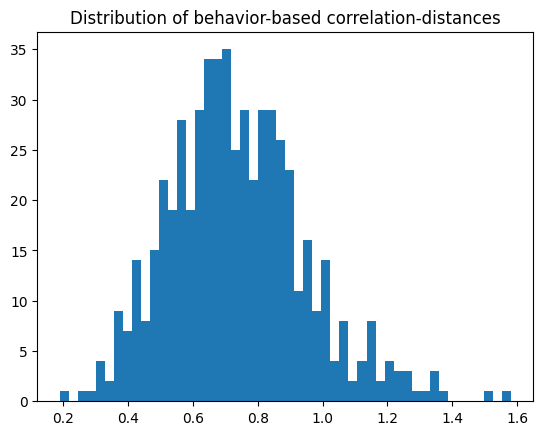

In [20]:
plt.hist(behav_dist, 50)
plt.title('Distribution of behavior-based correlation-distances')
plt.show()

### Note, I'm adding the subject IDs to this figure
This helps us evaluate whether anybody stands out.  I feel that subject 604 stands out with more variable distances (weird that they are also the last subject in our list!  Just a coincidence).

Not much to worry about at the moment, but we should note that subject 604 could be a problem.  We'll likely want to look more carefully at how they behave in the brain-based distance measures too.  It would be worth it to take a look at their raw behavioral data to see if there's anything unusual about it.

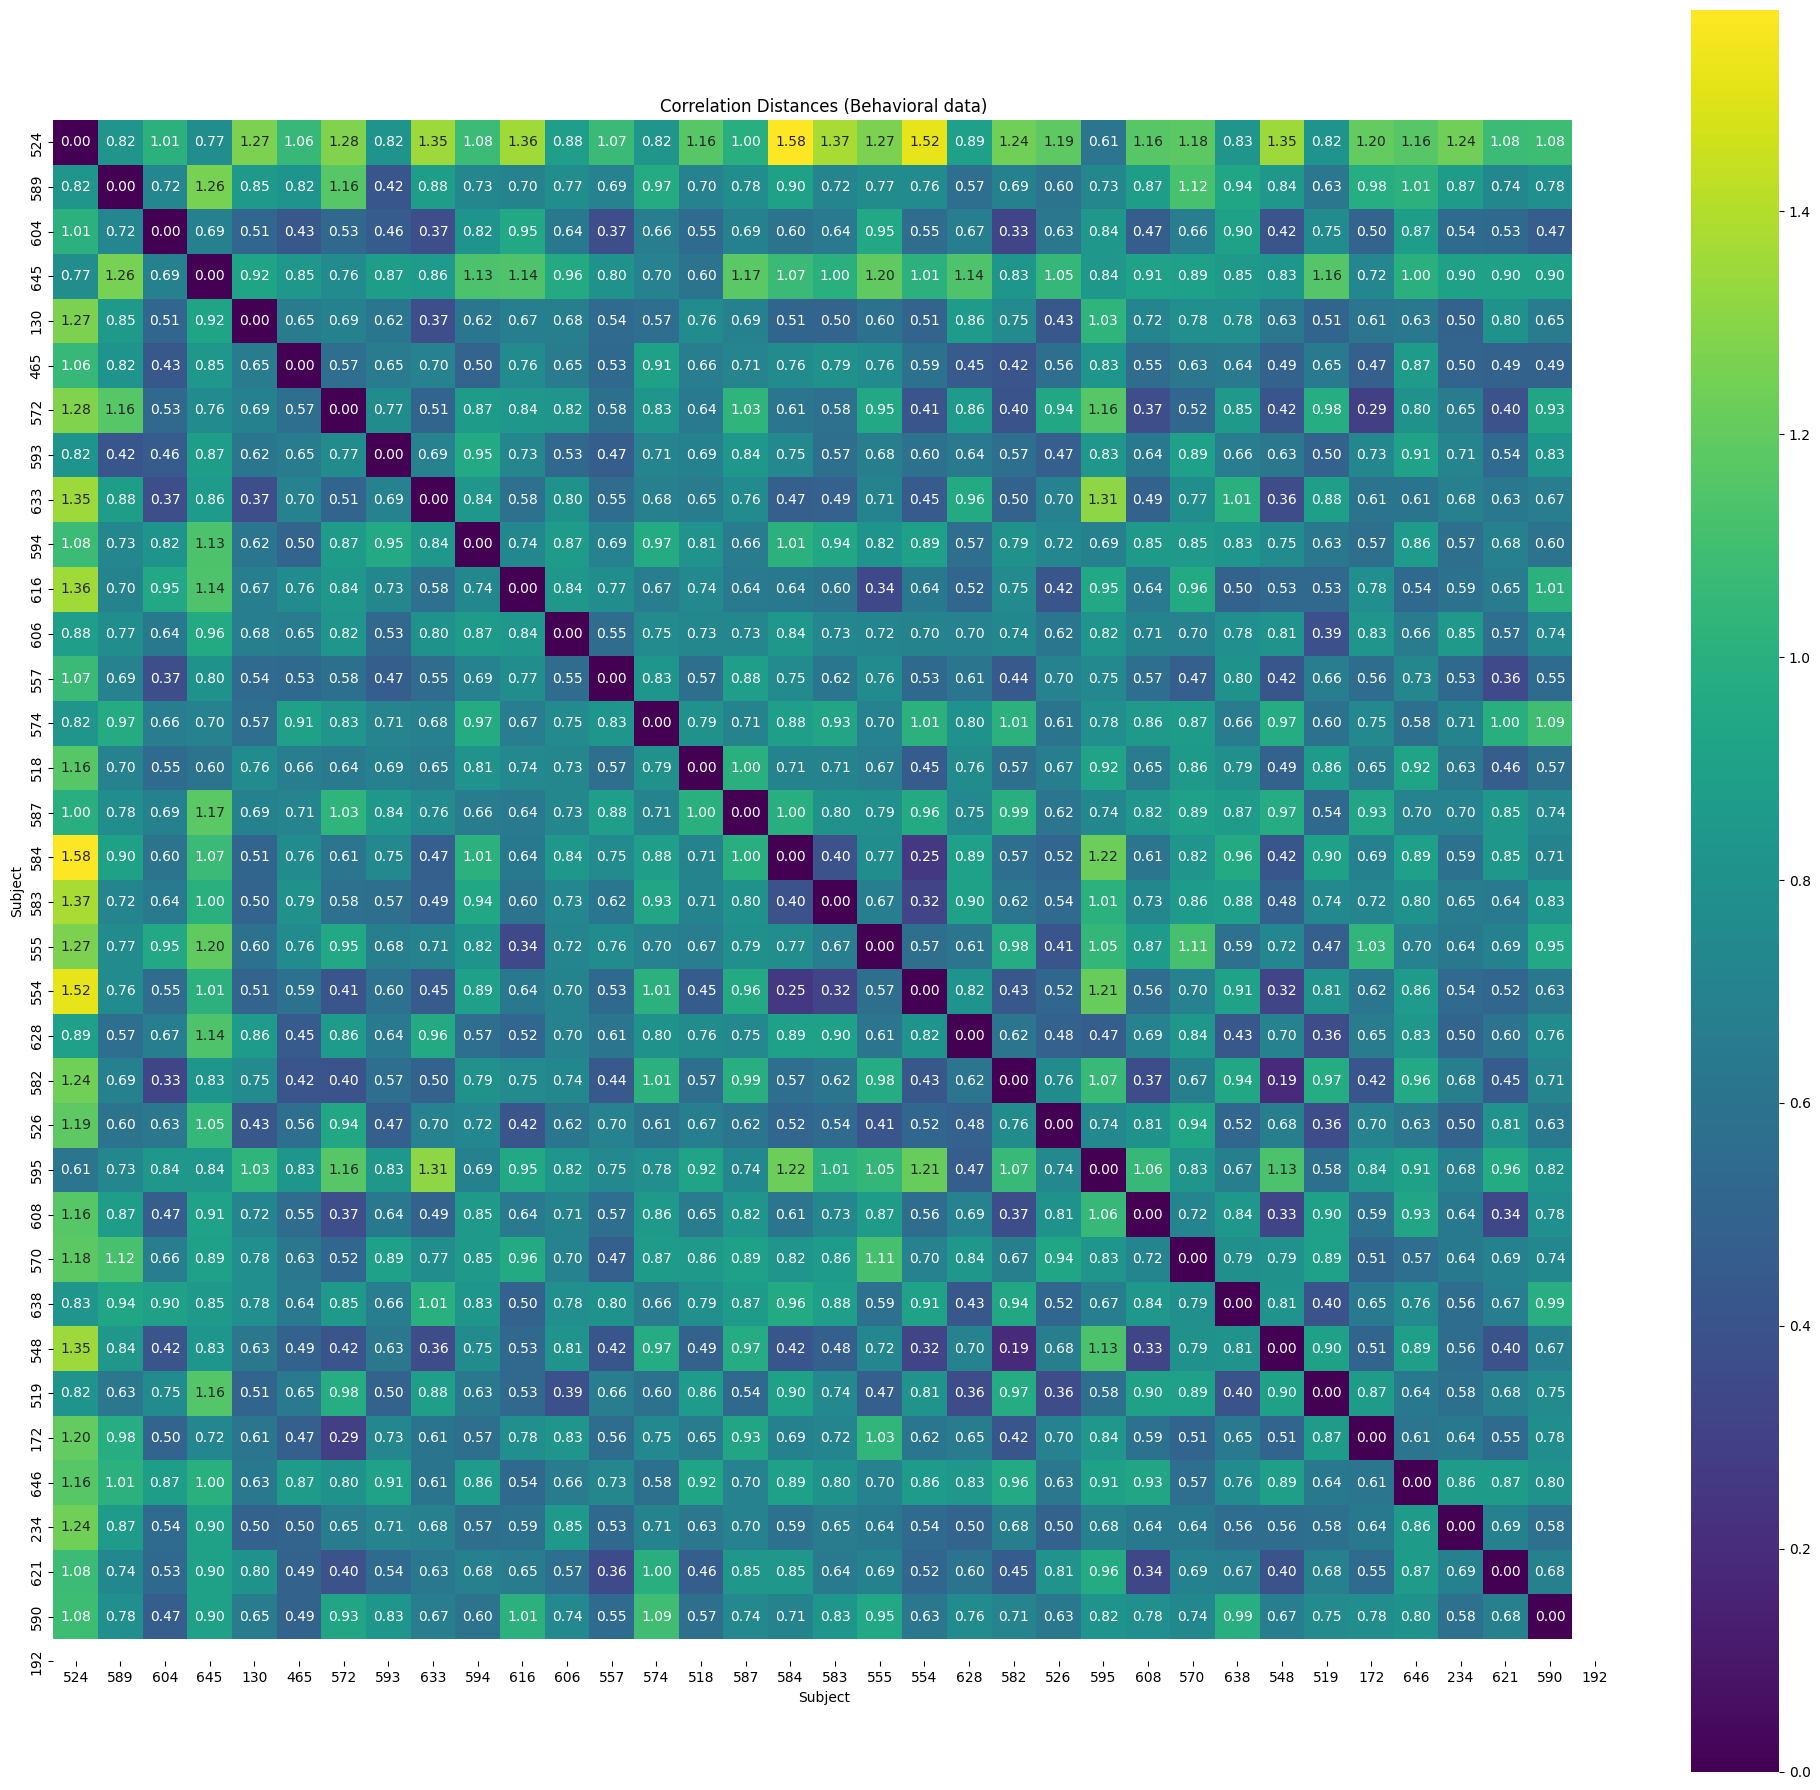

In [21]:
# plot the matrix

full_mat = behav_dist_mat + behav_dist_mat.T
np.fill_diagonal(full_mat, 0)  # Diagonal should be 0s

# Plot with Seaborn
plt.figure(figsize=(20, 18))
sns.heatmap(
    full_mat,
    annot=True,
    fmt='.2f',
    cmap='viridis',
    square=True,
    cbar=True,
    xticklabels=sub_ids,
    yticklabels=sub_ids,
)
plt.title('Correlation Distances (Behavioral data)')
plt.xlabel('Subject')
plt.ylabel('Subject')
plt.tight_layout()
plt.show()


# Step 5: Brain-based distances and Spearman correlation of brain_dist & behav_dist

Your code was nice and careful to keep the subject numbers lined up correctly.  

Questions I asked myself
* Could this be more effcient (actually I asked GPT and it had some suggestions)
    * If you only need the Pearson correlation, it is faster to code it yourself (I only know this from optimizing other code). `np.corrcoef` is designed to generate a matrix of correlations (we only want one value) and `pearsonr` generates statistics and things, which we don't need.
* It turns out my dictionary suggestion led to some inefficient code (sorry!). It was still useful, but I converted the dictionary into a 3D array (keeping your careful ordering) since plucking out values from a np.array is more efficient that making a queary of a dictionary over and over.
* How can I plot some data to get a feel for how the brain-based distance are behaving?
    * This was tough.  I started by thresholding the correlation map, finding "bigger" clusters and taking the peak voxels from these clusters.   I then plotted the data from these voxels
    * To view voxels that probably didn't have signal, I just randomly selected 5 voxels.  I'm sure there are more creative ideas out there, but I think this is good for now?

In [22]:
# Step 5: Compute pairwise similarity for each voxel and correlate with behavioral similarity

# GPT suggested using a home made pearson correlation, which is more efficient.
# I had recalled the numpy and scipy methods had inefficiencies when all you want is the one correlation.


def fast_pearson(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    n = x.size
    sum_x = x.sum()
    sum_y = y.sum()
    sum_x2 = np.dot(x, x)
    sum_y2 = np.dot(y, y)
    sum_xy = np.dot(x, y)

    numerator = n * sum_xy - sum_x * sum_y
    denominator = np.sqrt((n * sum_x2 - sum_x**2) * (n * sum_y2 - sum_y**2))

    return numerator / denominator if denominator != 0 else 0.0

In [23]:
# GPT said it would be faster to stack the matrices first, instead of repeatedly accessing a dictionary (sorry, I hadn't realized it was inefficient)
fmri_matrix = np.stack(
    [fmri_data_dict[sub_id] for sub_id in sorted_sub_ids]
)  # shape: (n_subs, n_timepoints, n_voxels)


# to be safe, calcuate n_voxels now
first_key = next(iter(fmri_data_dict))
n_voxels = fmri_data_dict[first_key].shape[1]

spearman_corrs = np.zeros(n_voxels)


for v in range(n_voxels):
    voxel_dist = []
    for i in range(n_subs):
        voxel_sub_i = fmri_matrix[i, :, v]
        for j in range(i + 1, n_subs):
            voxel_sub_j = fmri_matrix[j, :, v]
            r = fast_pearson(voxel_sub_i, voxel_sub_j)
            if np.isnan(r):
                voxel_dist.append(np.nan)
            voxel_dist.append(1 - r)
    rho, _ = spearmanr(behav_dist, voxel_dist)
    spearman_corrs[v] = rho
    if v % 10000 == 0 and v > 0:
        print(f'...finished {v} of {n_voxels} voxels')

...finished 10000 of 153007 voxels
...finished 20000 of 153007 voxels
...finished 30000 of 153007 voxels
...finished 40000 of 153007 voxels
...finished 50000 of 153007 voxels
...finished 60000 of 153007 voxels
...finished 70000 of 153007 voxels
...finished 80000 of 153007 voxels
...finished 90000 of 153007 voxels
...finished 100000 of 153007 voxels
...finished 110000 of 153007 voxels
...finished 120000 of 153007 voxels
...finished 130000 of 153007 voxels
...finished 140000 of 153007 voxels
...finished 150000 of 153007 voxels


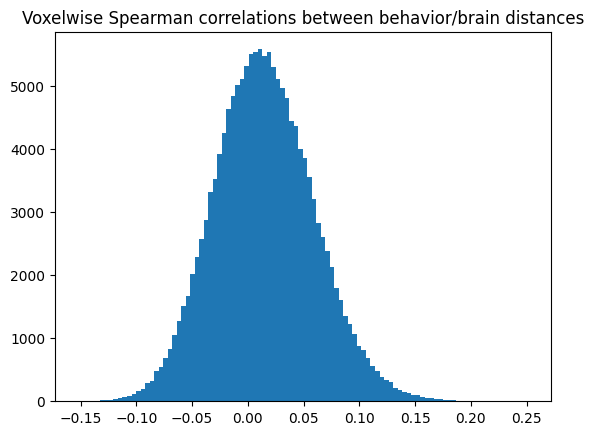

In [24]:
plt.hist(spearman_corrs, 100)
plt.title('Voxelwise Spearman correlations between behavior/brain distances')
plt.show()

In [25]:
group_mask_data = group_mask.get_fdata().astype(bool)

output_data = np.zeros(group_mask_data.shape)
output_data[group_mask_data] = spearman_corrs
spearman_img = nib.Nifti1Image(
    output_data, affine=group_mask.affine, header=group_mask.header
)
# nib.save(spearman_img, 'spearman_correlations.nii.gz')


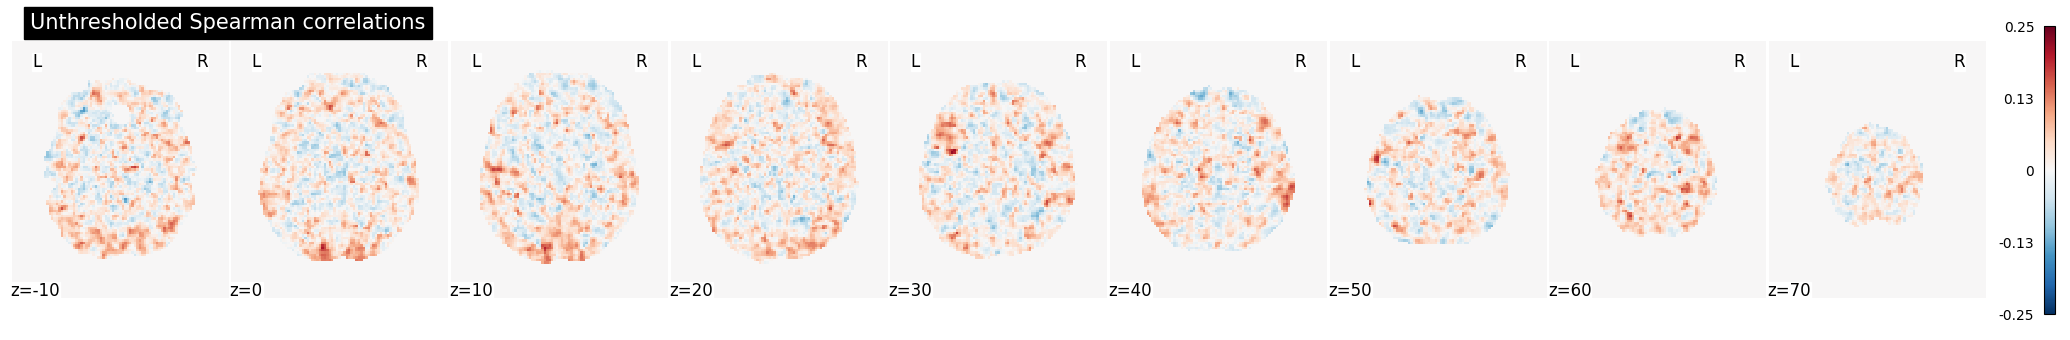

In [26]:
plotting.plot_stat_map(
    spearman_img,
    display_mode='z',
    cut_coords=z_slices,
    threshold=None,
    title='Unthresholded Spearman correlations',
)

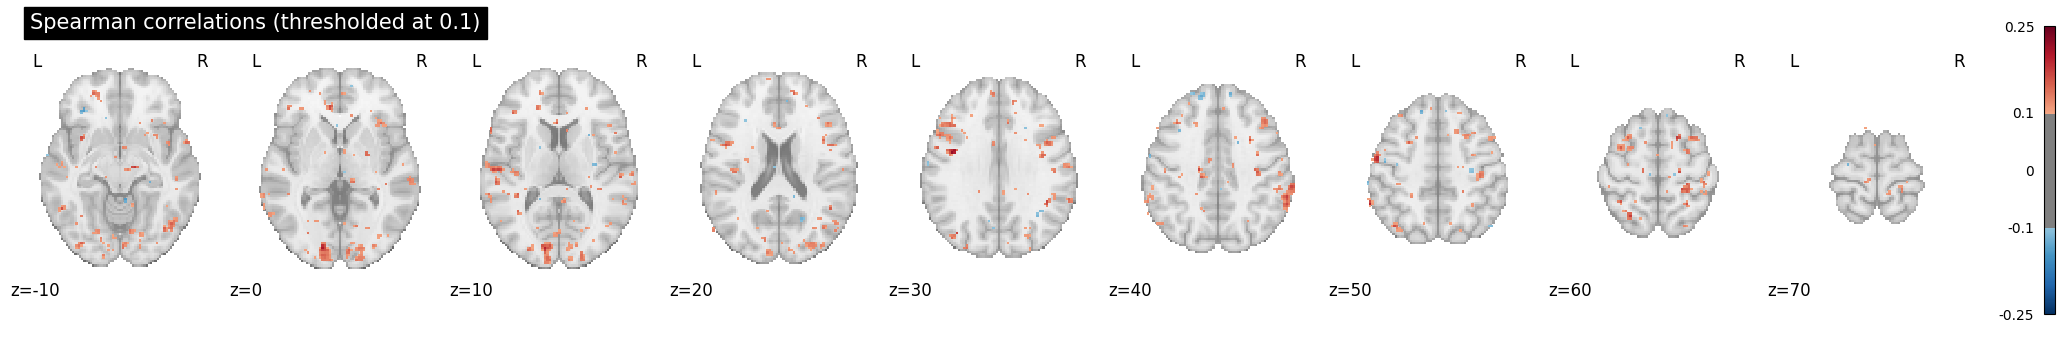

In [27]:
thresh = 0.1
plotting.plot_stat_map(
    spearman_img,
    display_mode='z',
    cut_coords=z_slices,
    threshold=thresh,
    title=f'Spearman correlations (thresholded at {thresh})',
)

In [28]:
import numpy as np
from nilearn.image import threshold_img
from nilearn.regions import connected_regions

# Threshold image to .2 and extract clusters
thresholded_img = threshold_img(spearman_img, threshold=0.1)
regions_img, index = connected_regions(thresholded_img, min_region_size=10)


/tmp/ipykernel_30400/911642043.py:6: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresholded_img = threshold_img(spearman_img, threshold=0.1)


In [29]:
from scipy import ndimage

cluster_size = 20

# Step 1: Threshold your spearman map
threshold = 0.15
binary_mask = output_data > threshold

# Step 2: Label connected clusters (26-connectivity for 3D)
structure = ndimage.generate_binary_structure(rank=3, connectivity=2)  # 26-connectivity
labeled_array, num_features = ndimage.label(binary_mask, structure=structure)

# Step 3: Count voxels per cluster
cluster_sizes = np.bincount(labeled_array.ravel())

# Step 4: Find clusters larger than 10 voxels (skip cluster 0, which is background)
large_clusters = np.where(cluster_sizes > cluster_size)[0]
large_clusters = large_clusters[large_clusters != 0]  # remove background label

# Count how many clusters pass the threshold
n_large_clusters = len(large_clusters)
print(
    f'Found {n_large_clusters} clusters with more than {cluster_size} voxels and r > {threshold}'
)

Found 3 clusters with more than 20 voxels and r > 0.15


In [30]:
peak_voxels_3d = []

for c in large_clusters:
    cluster_mask = labeled_array == c
    cluster_values = output_data * cluster_mask  # mask out other clusters
    peak_3d_index = np.unravel_index(np.argmax(cluster_values), output_data.shape)
    peak_voxels_3d.append(peak_3d_index)

# Create masker (as you said, consistent with original data extraction)
masker = NiftiMasker(mask_img=group_mask)
masker.fit()  # important!

# We'll transform a dummy image just to get the mapping
flat_data = masker.transform(
    nib.Nifti1Image(output_data, affine=group_mask.affine)
)  # shape (1, n_voxels)
mask_3d = masker.mask_img_.get_fdata().astype(bool)
mask_1d = mask_3d.ravel()

# Convert each peak voxel to a masked index
masked_indices = []

for voxel_3d in peak_voxels_3d:
    flat_index = np.ravel_multi_index(voxel_3d, output_data.shape)
    if not mask_1d[flat_index]:
        print(f'Voxel {voxel_3d} is not in the mask.')
        continue
    # Find its index in the 1D masked array
    masked_index = np.flatnonzero(mask_1d[: flat_index + 1]).shape[0] - 1
    masked_indices.append(masked_index)

print('Masked voxel indices (1D):', masked_indices)


Masked voxel indices (1D): [54164, 107117, 151148]


In [31]:
print(peak_voxels_3d)

[(np.int64(37), np.int64(21), np.int64(38)), (np.int64(54), np.int64(15), np.int64(38)), (np.int64(73), np.int64(36), np.int64(52))]


In [32]:
def get_bold_dist_mat_plots(fmri_matrix, behav_dist, voxel_index, voxel_3d, sub_ids):
    """
    Computes BOLD correlation distances at a given voxel across subjects,
    compares to behavioral distances, and visualizes both.

    Parameters:
    - fmri_matrix: shape (n_subjects, n_timepoints, n_voxels)
    - behav_dist: 1D array of pairwise behavioral distances
    - voxel_index: integer index into the 3rd dimension of fmri_matrix
    - voxel_3d: 3-tuple of (x, y, z) voxel grid coordinates
    - sub_ids: list of subject identifiers

    Returns:
    - bold_dist_mat: full symmetric distance matrix
    - bold_dist_vec: condensed distance vector (upper triangle, no diagonal)
    - rho: Spearman correlation with behav_dist
    """
    n_subs = fmri_matrix.shape[0]
    bold_dist_mat = np.zeros((n_subs, n_subs))
    bold_dist_vec = []

    # Compute upper triangle of distance matrix
    for i in range(n_subs):
        ts_i = fmri_matrix[i, :, voxel_index]
        for j in range(i + 1, n_subs):
            ts_j = fmri_matrix[j, :, voxel_index]
            r = fast_pearson(ts_i, ts_j)
            dist = 1 - r
            bold_dist_mat[i, j] = dist
            bold_dist_vec.append(dist)

    # Spearman correlation
    rho, _ = spearmanr(behav_dist, bold_dist_vec)

    # Plot distance correlation
    _plot_dist_scatter(bold_dist_vec, behav_dist, rho, voxel_3d)

    # Symmetrize matrix
    bold_dist_mat_full = bold_dist_mat + bold_dist_mat.T

    # Plot heatmap
    _plot_distance_heatmap(bold_dist_mat_full, voxel_3d, sub_ids)

    return bold_dist_mat_full, bold_dist_vec, rho


def _plot_dist_scatter(bold_vec, behav_vec, rho, voxel_3d):
    plt.figure()
    plt.plot(bold_vec, behav_vec, '.', alpha=0.7)
    plt.xlabel('BOLD distance')
    plt.ylabel('Behavioral distance')
    plt.title(
        f'Spearman r = {rho:.3f}\nvoxel = {tuple(map(int, voxel_3d))} (grid index)'
    )
    plt.tight_layout()
    plt.show()


def _plot_distance_heatmap(dist_mat, voxel_3d, sub_ids):
    plt.figure(figsize=(20, 18))
    sns.heatmap(
        dist_mat,
        annot=True,
        fmt='.2f',
        cmap='viridis',
        square=True,
        cbar=True,
        xticklabels=sub_ids,
        yticklabels=sub_ids,
        annot_kws={'size': 8},
    )
    plt.title(
        f'Pairwise BOLD Distances\nvoxel = {tuple(map(int, voxel_3d))} (grid index)'
    )
    plt.xlabel('Subject')
    plt.ylabel('Subject')
    plt.tight_layout()
    plt.show()

### Exploring voxels that had larger correlations (relative to the correlations in the data)

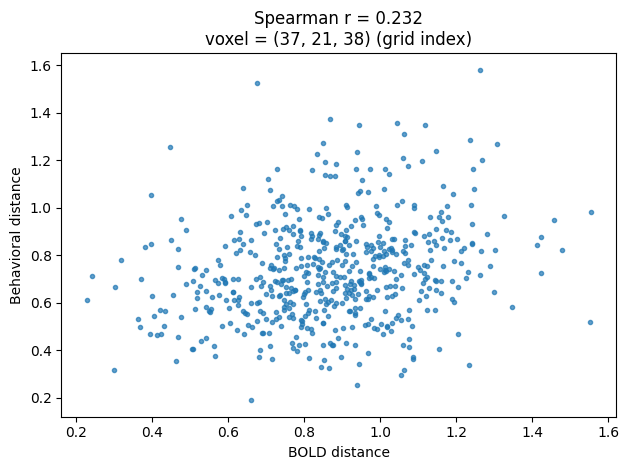

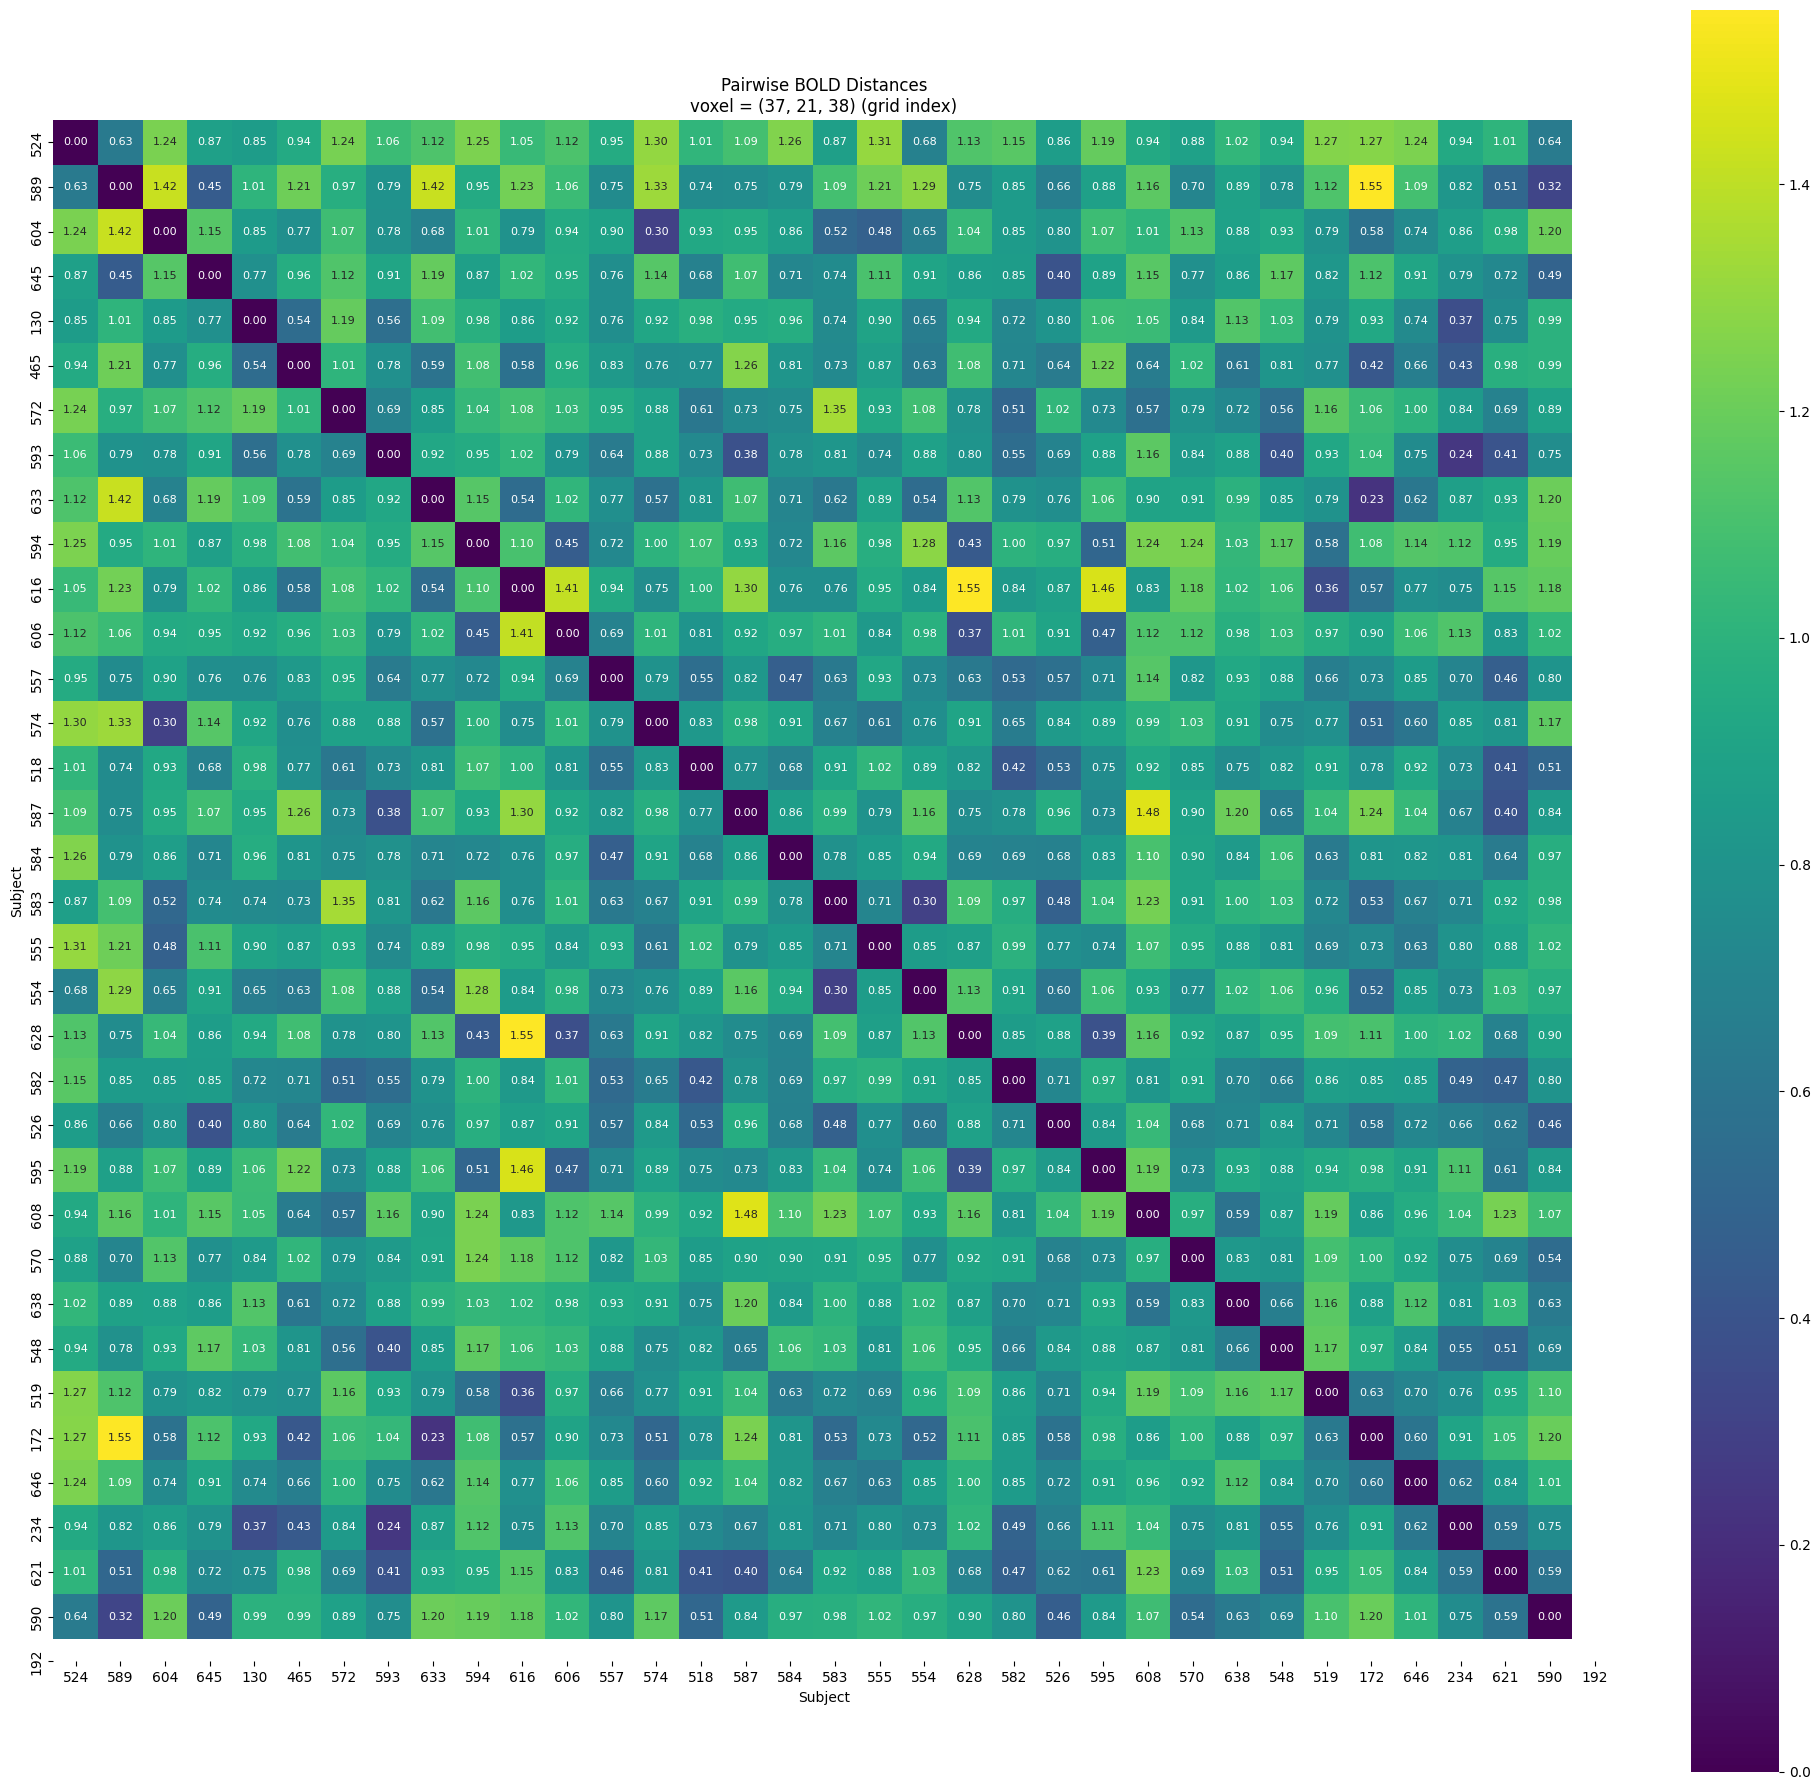

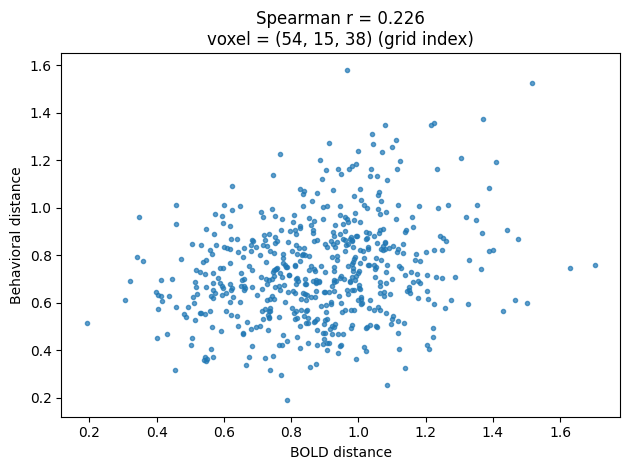

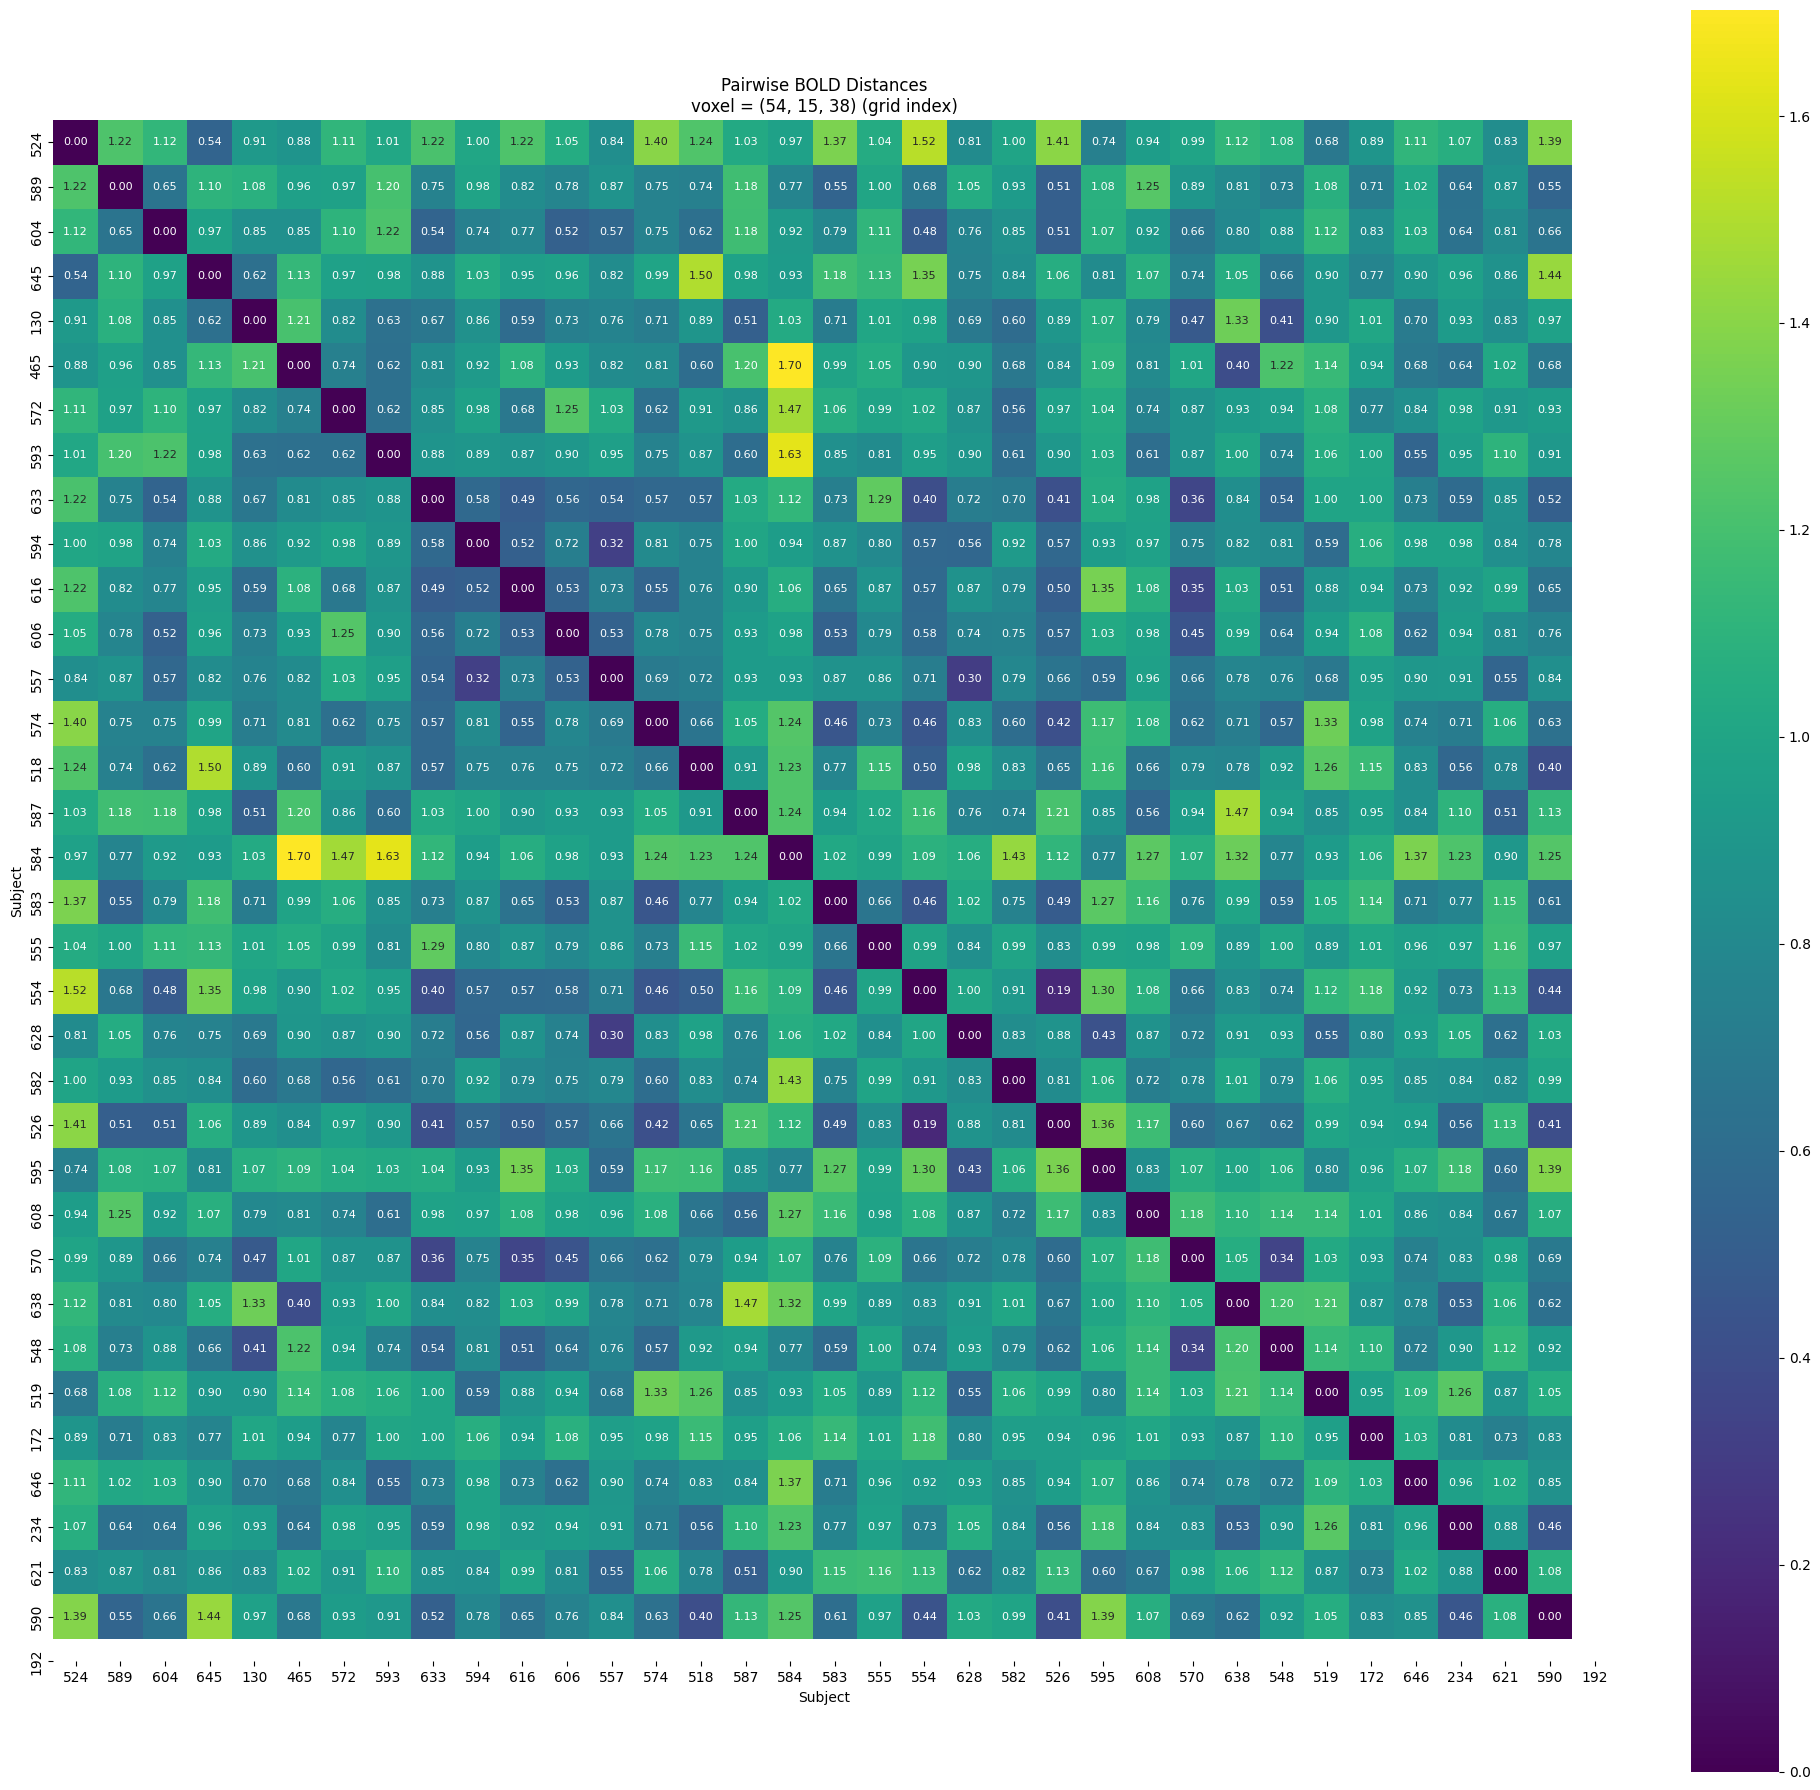

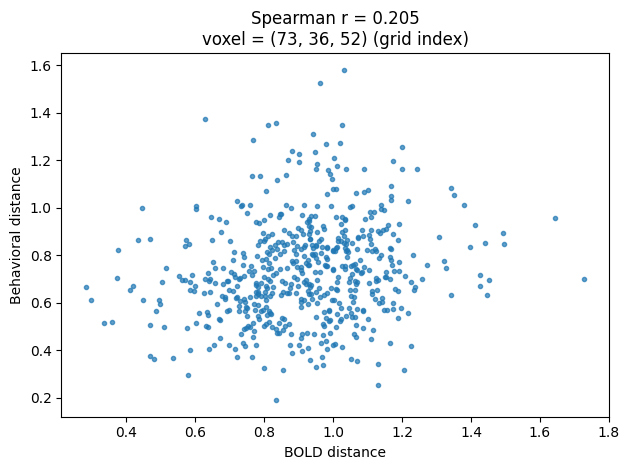

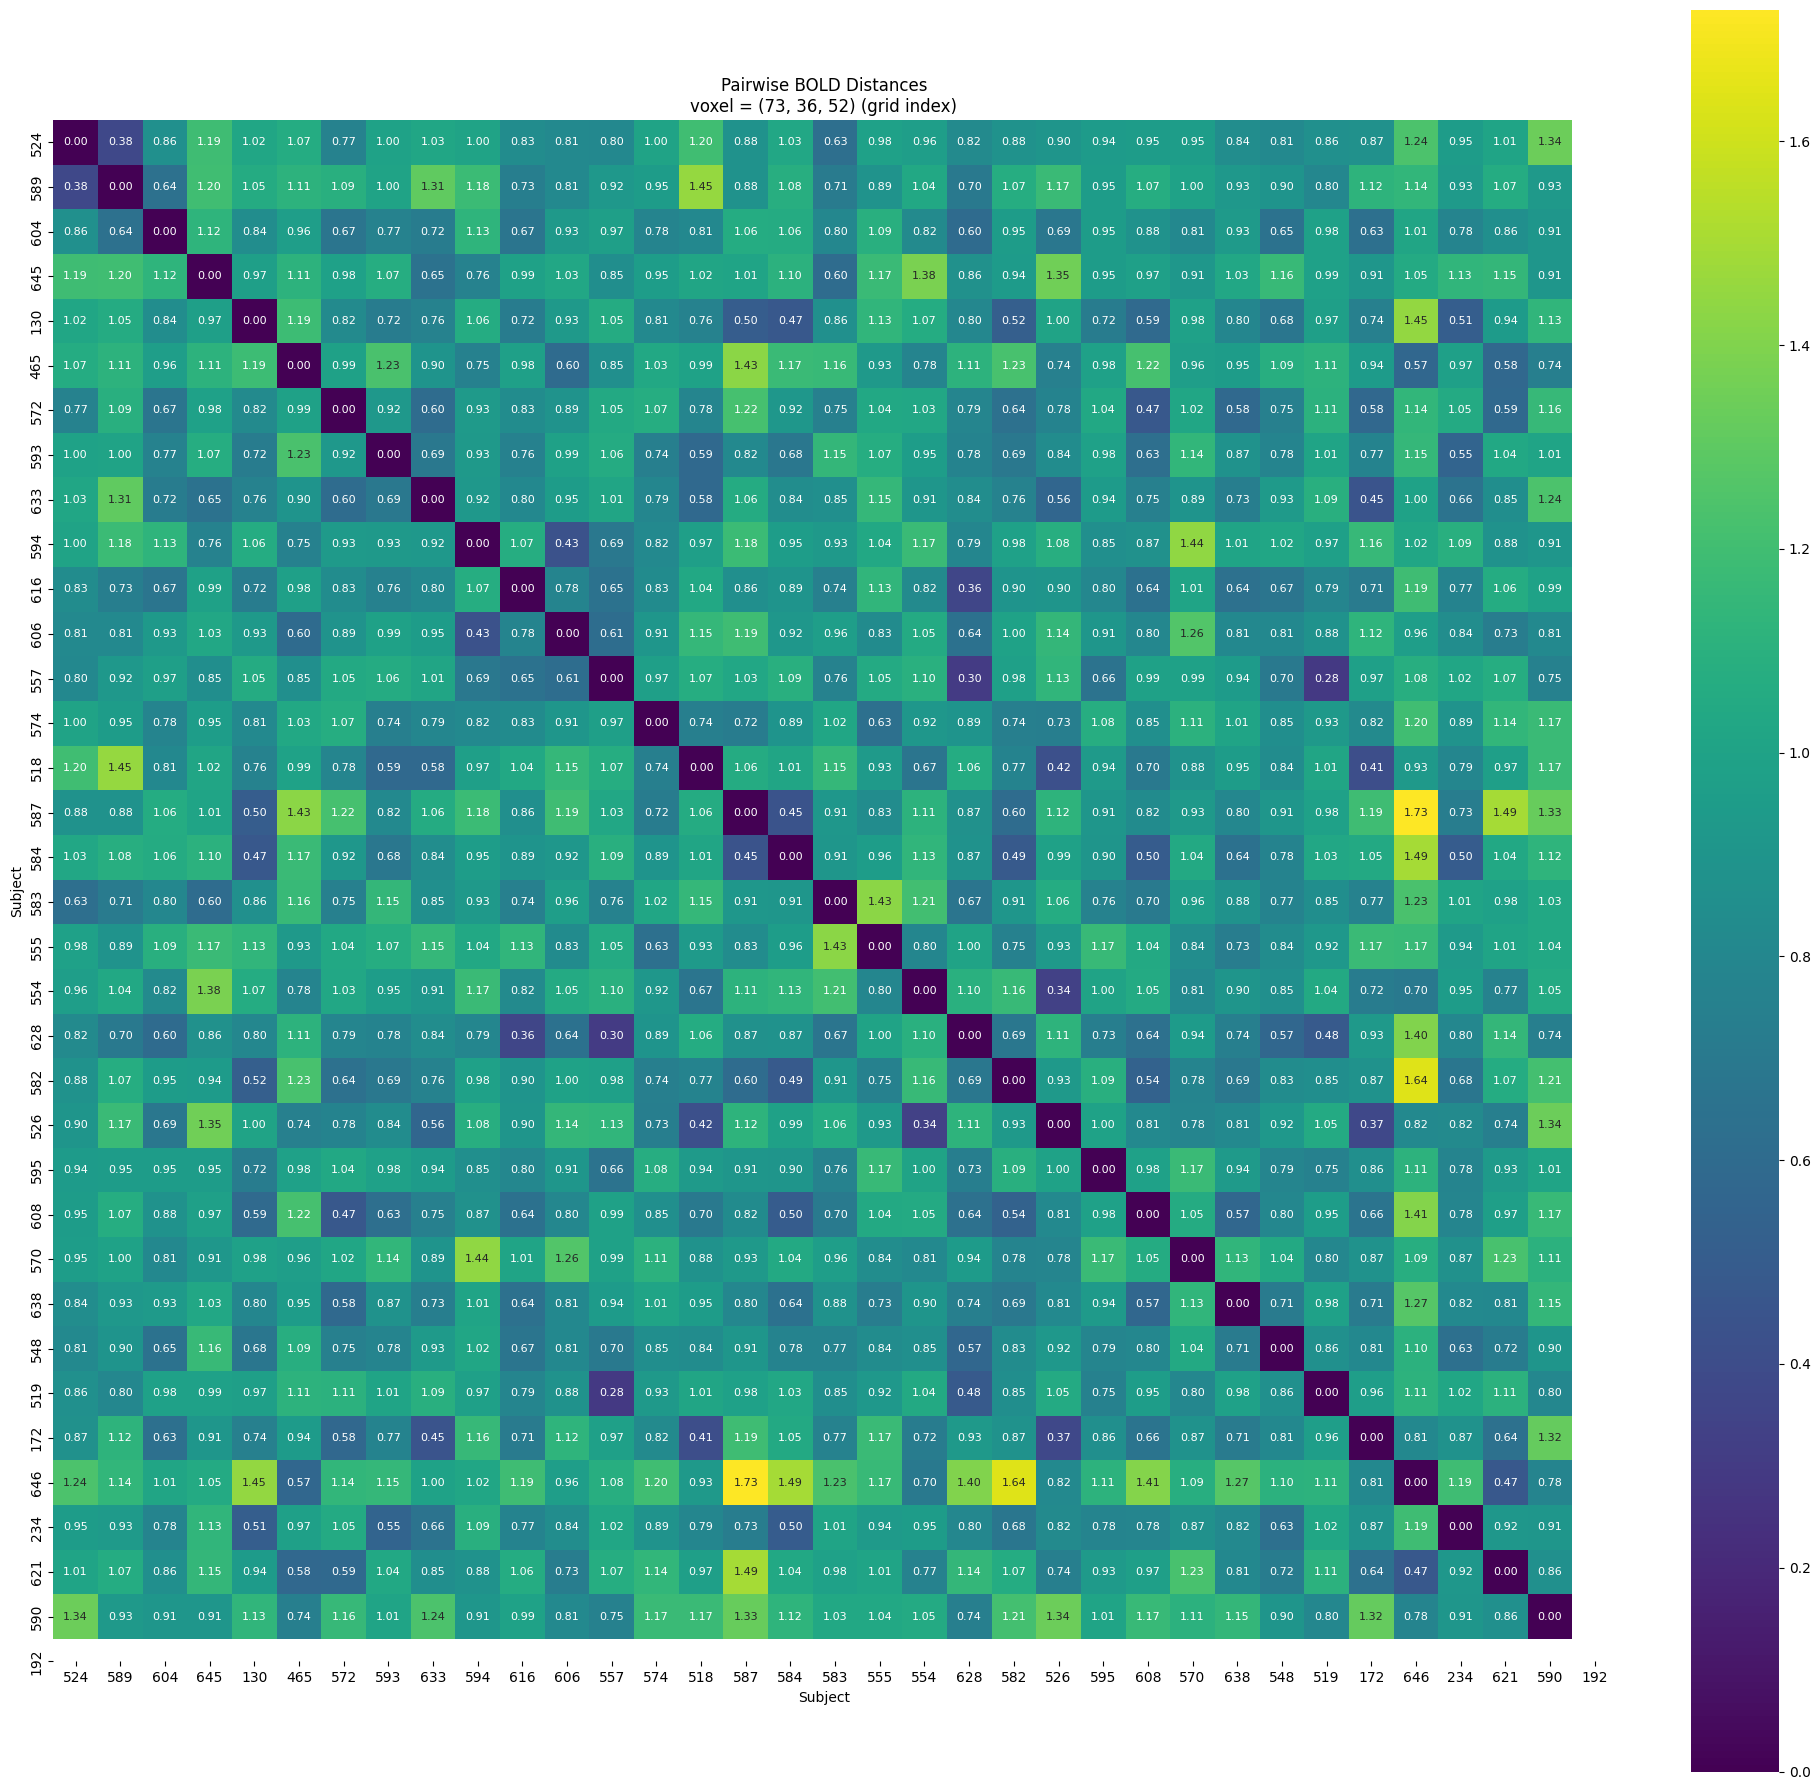

In [33]:
for ind in range(3):
    v = masked_indices[ind]
    v_3d = peak_voxels_3d[ind]

    bold_dist_mat1, bold_dist_vec1, rho1 = get_bold_dist_mat_plots(
        fmri_matrix, behav_dist, v, v_3d, sub_ids
    )


### Exploring random voxels


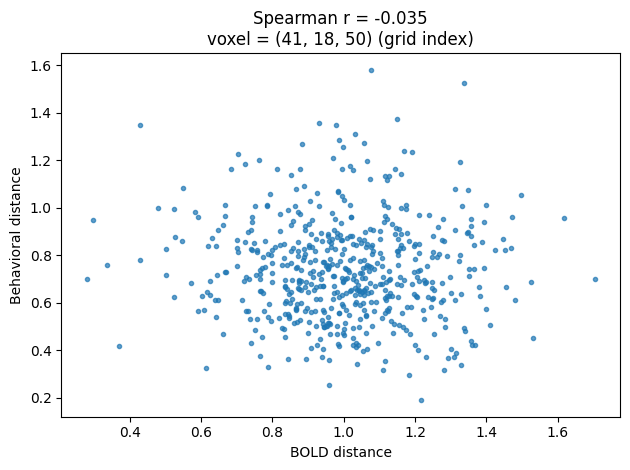

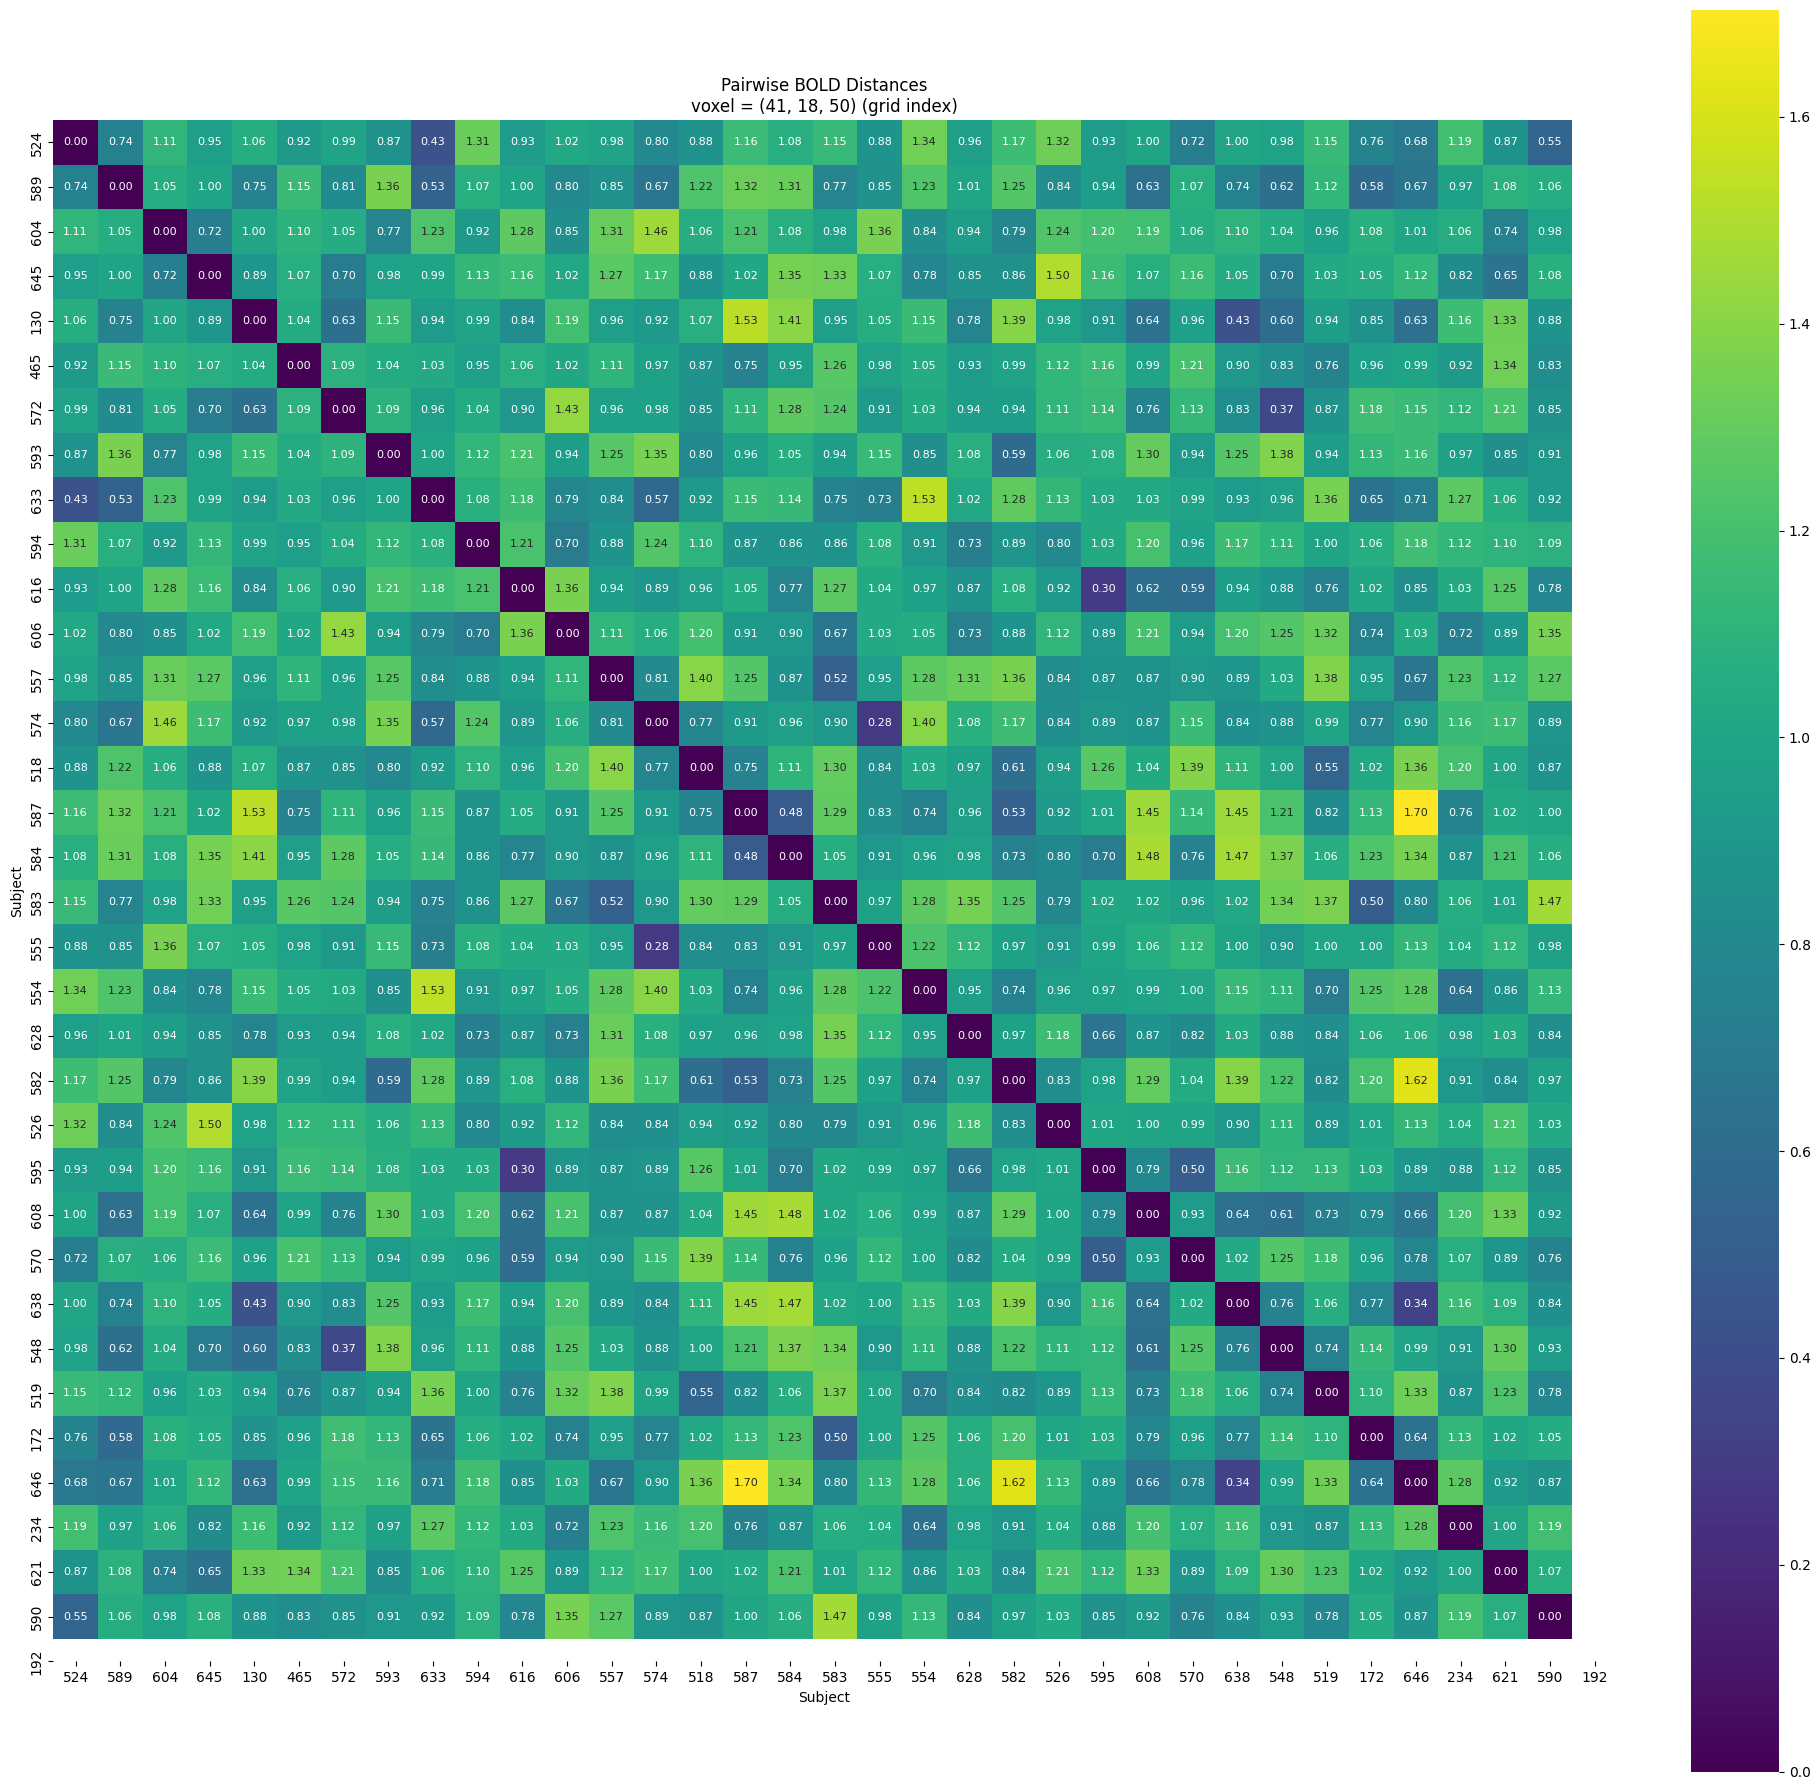

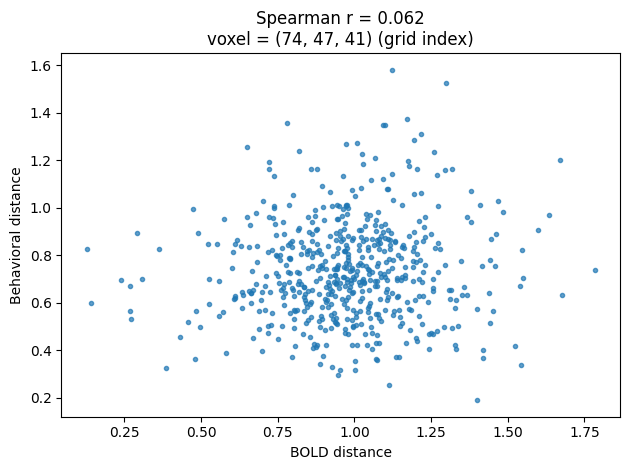

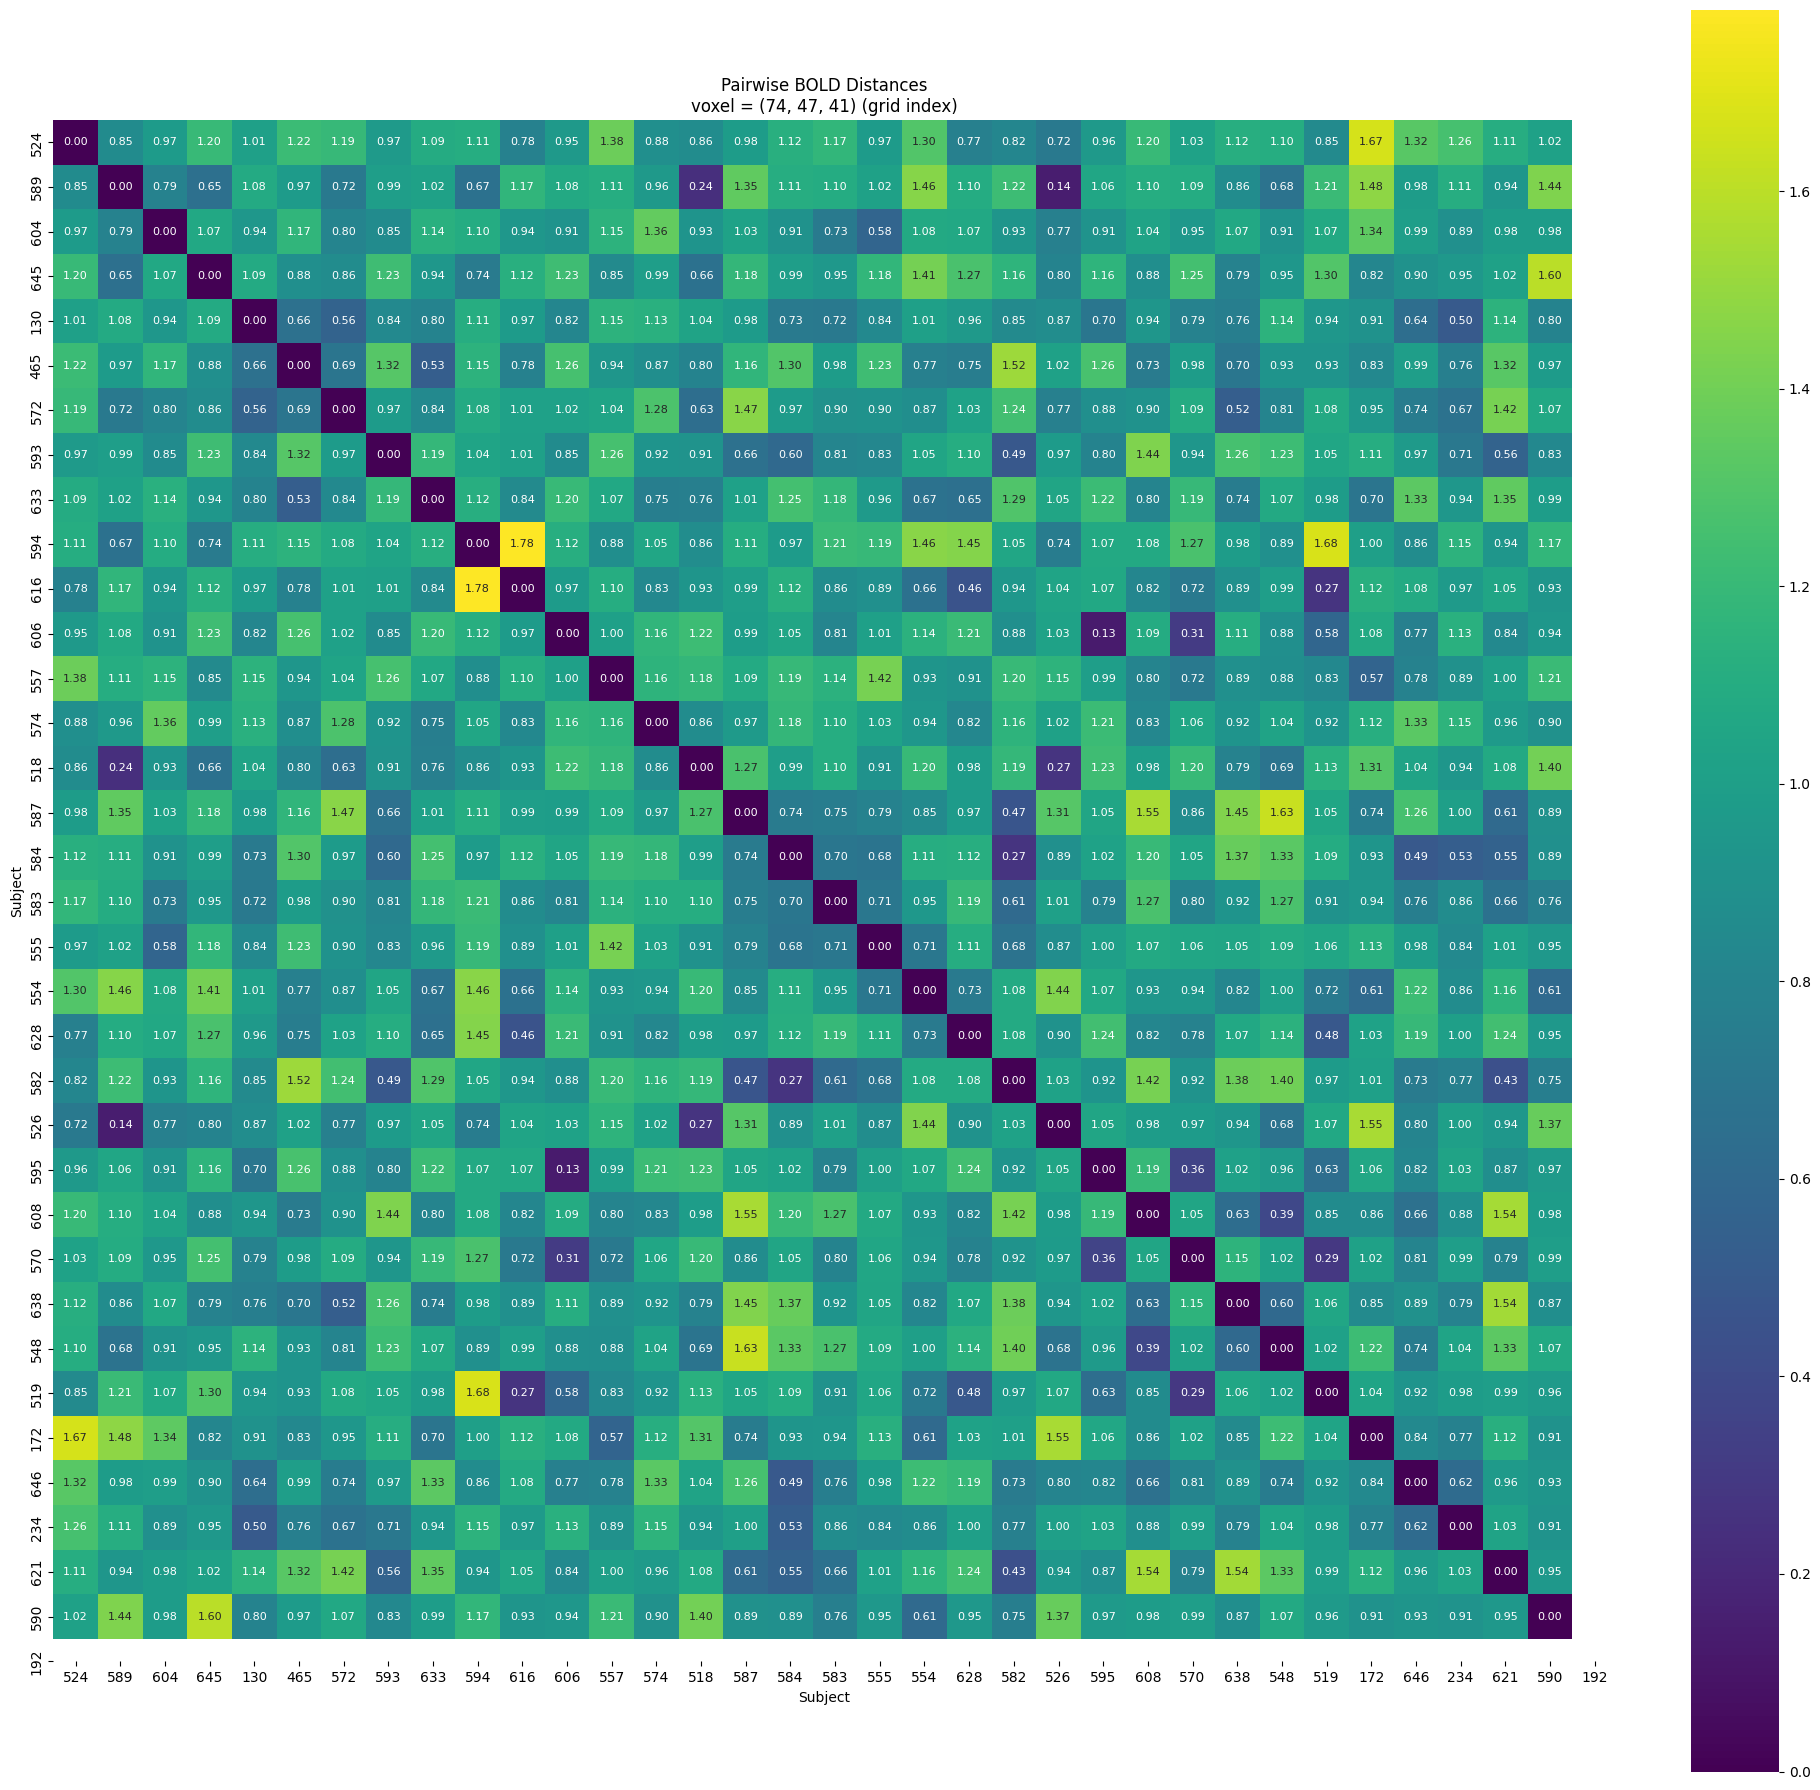

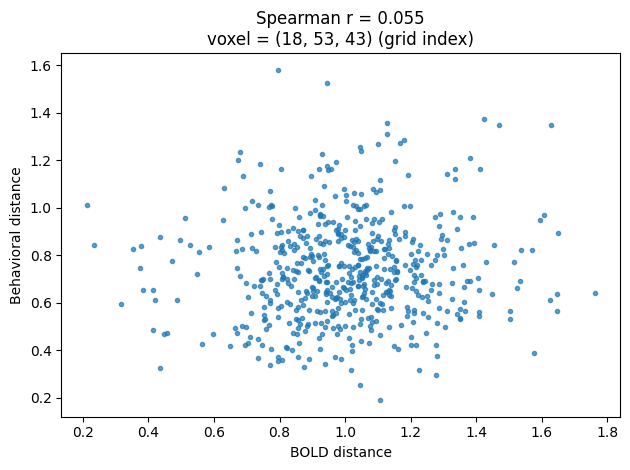

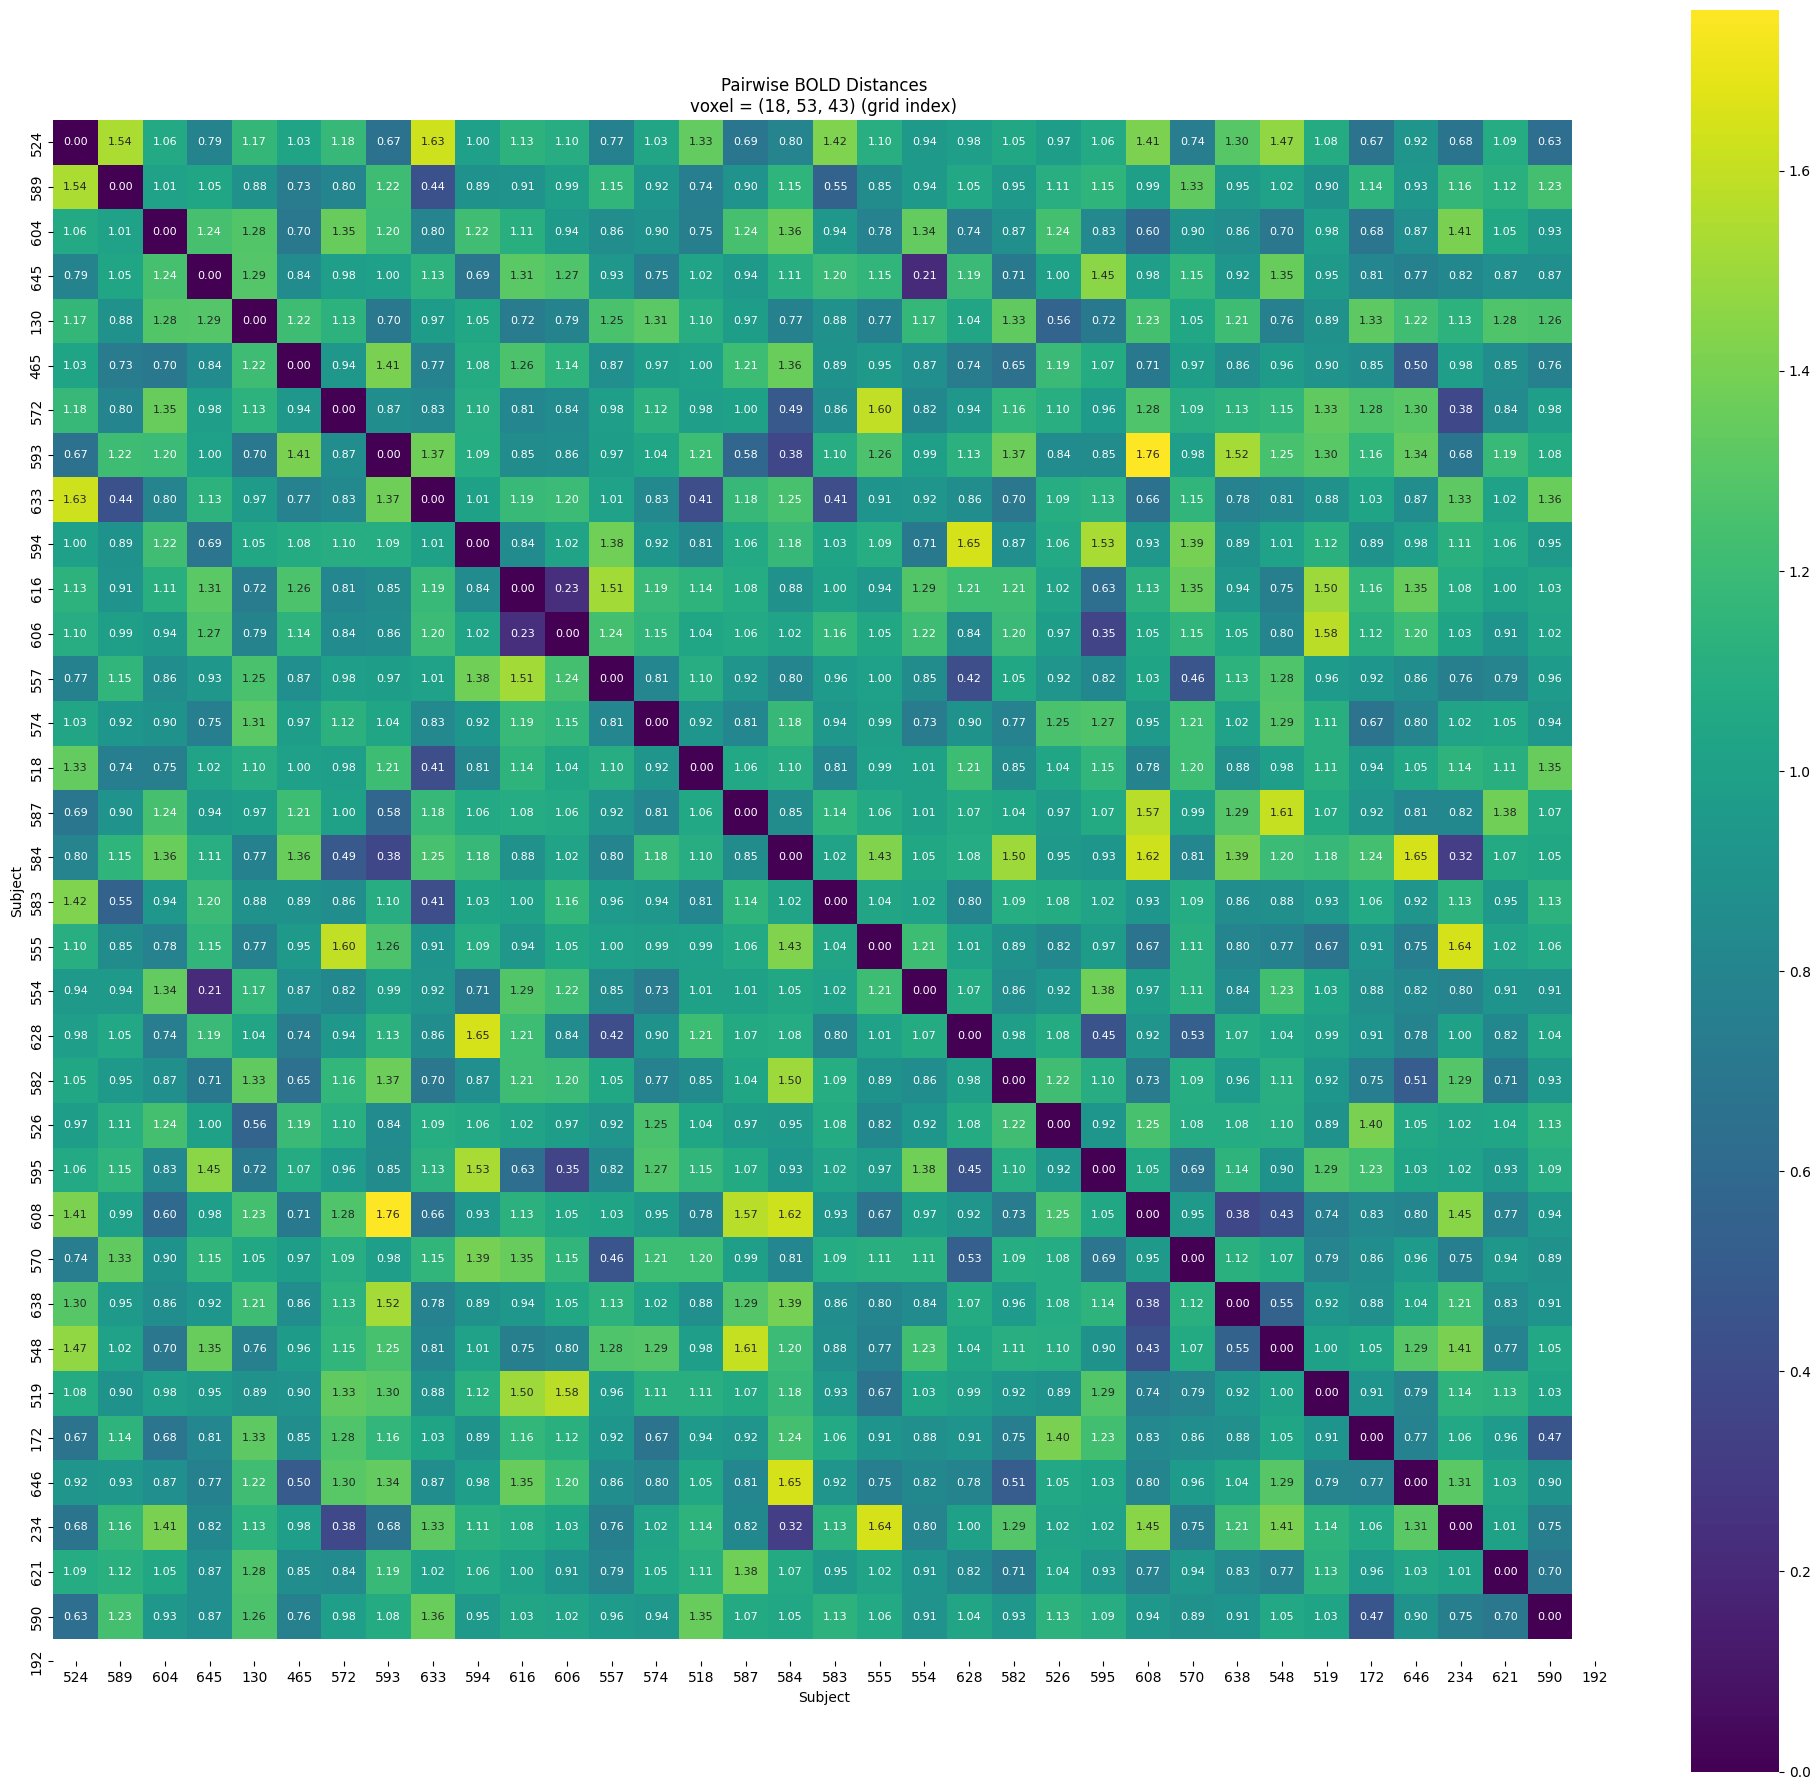

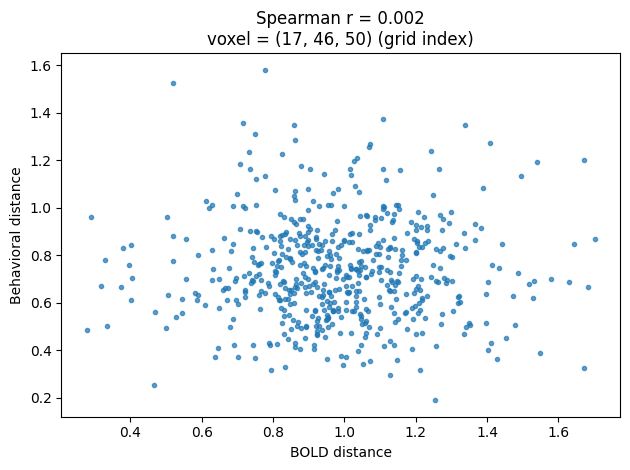

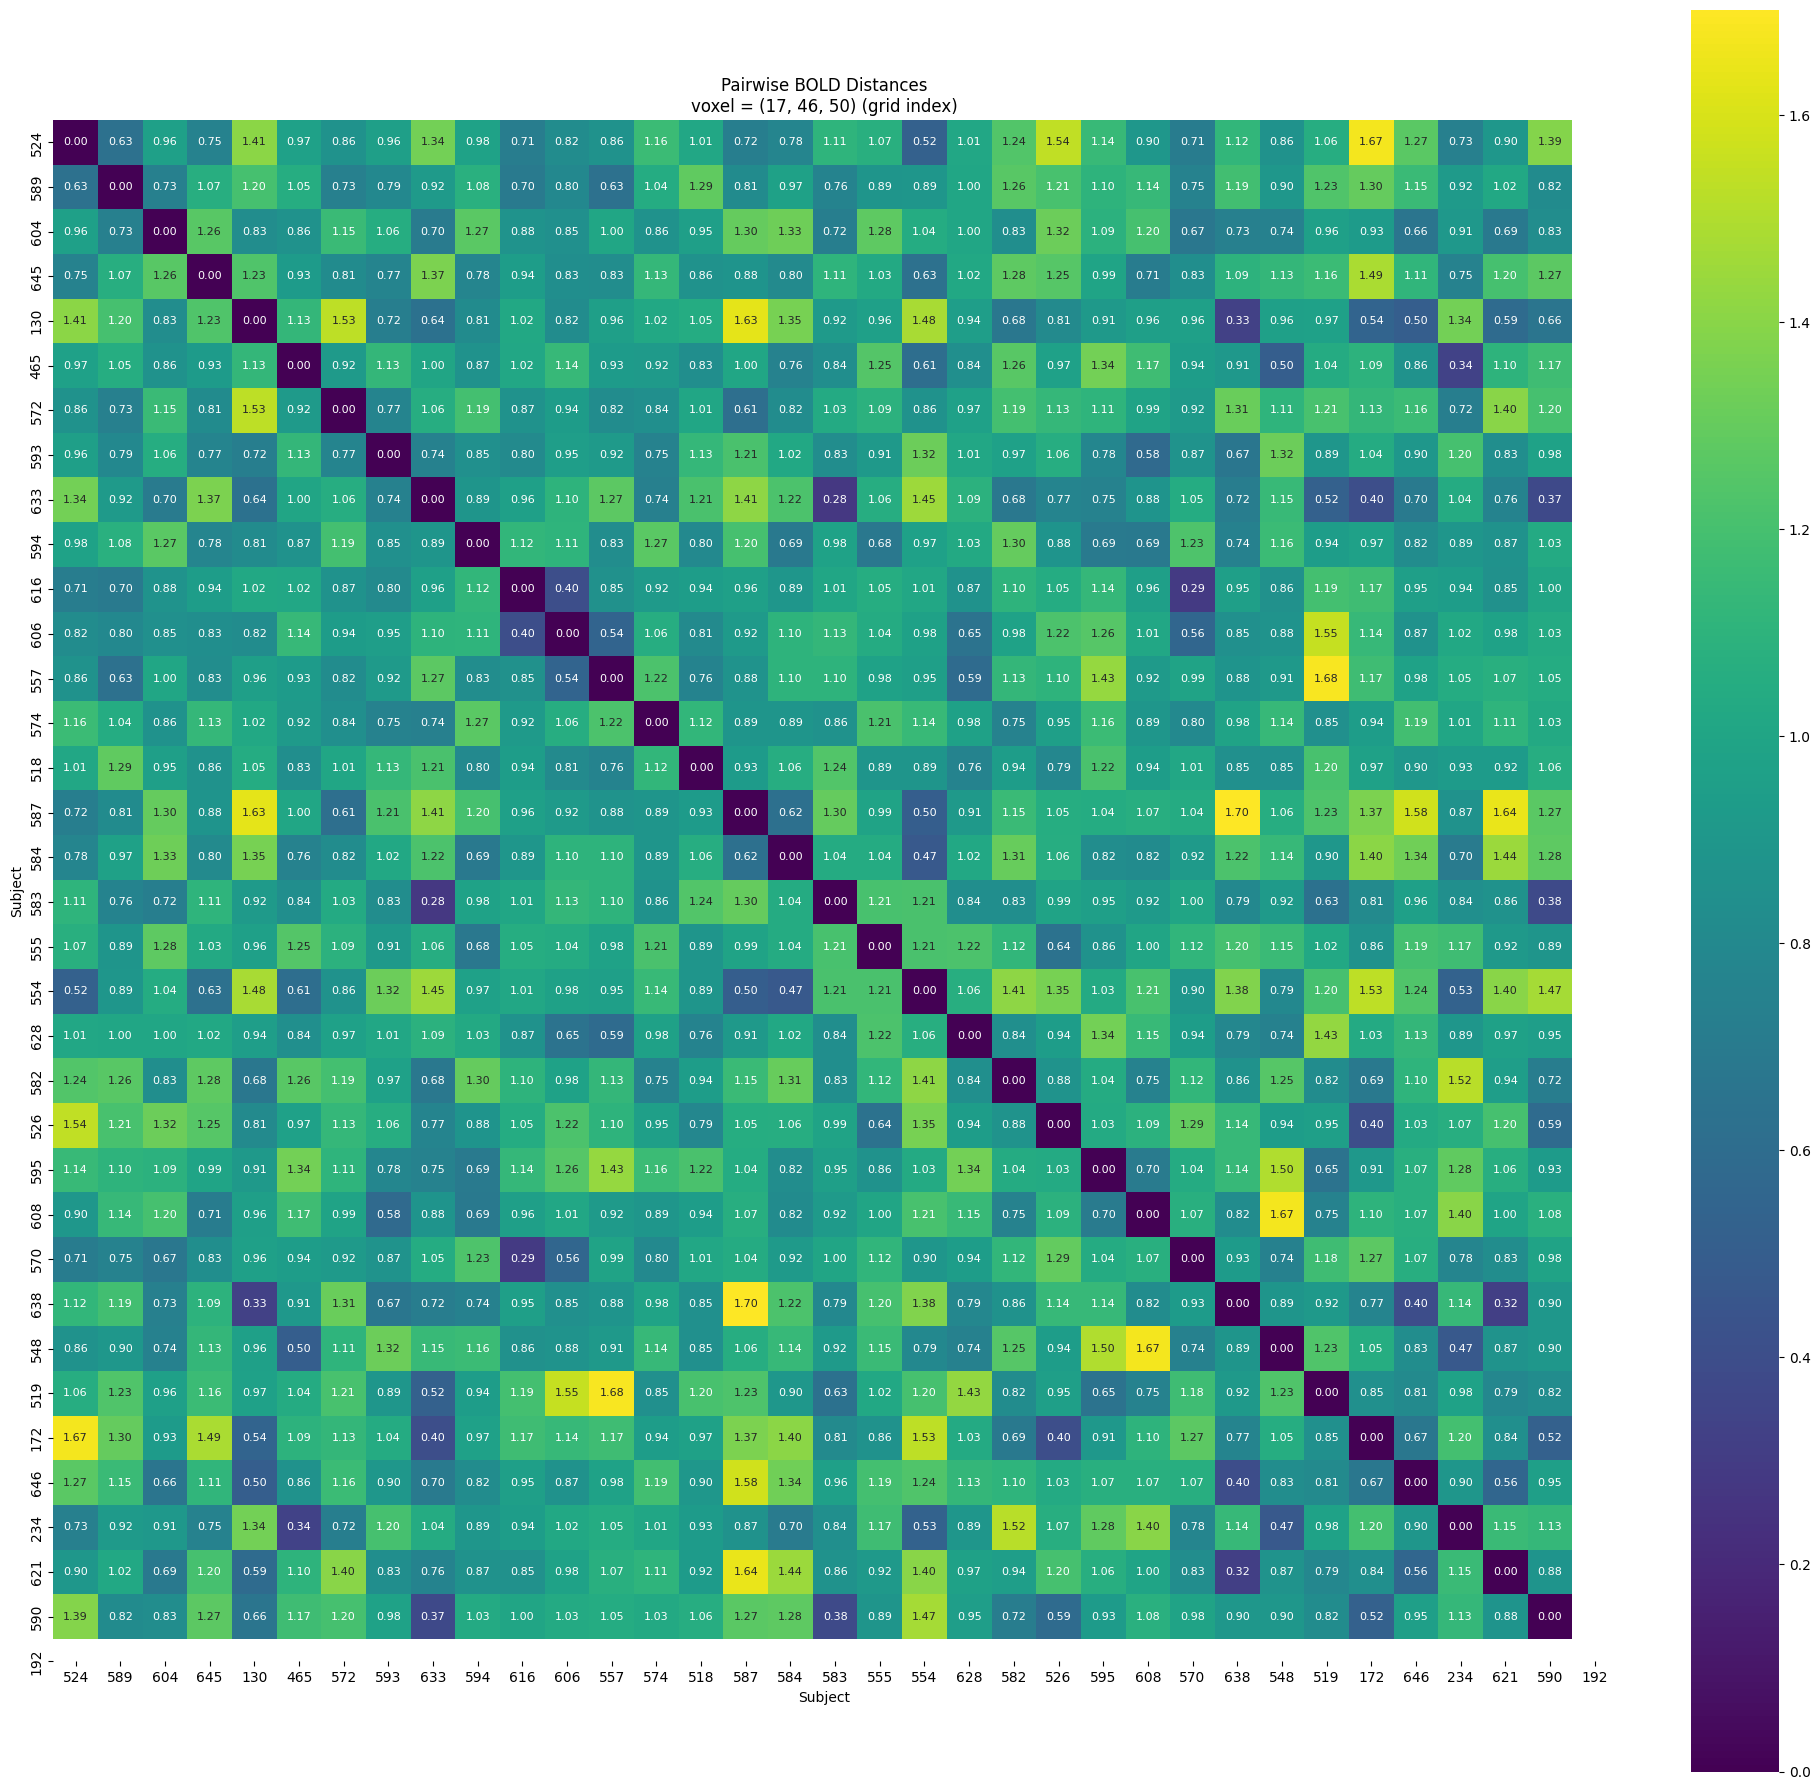

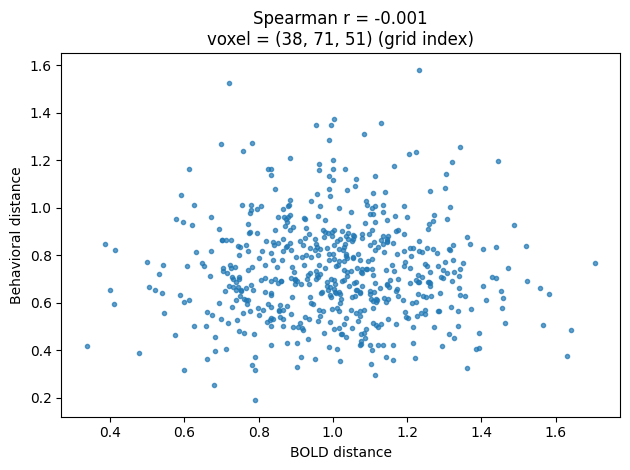

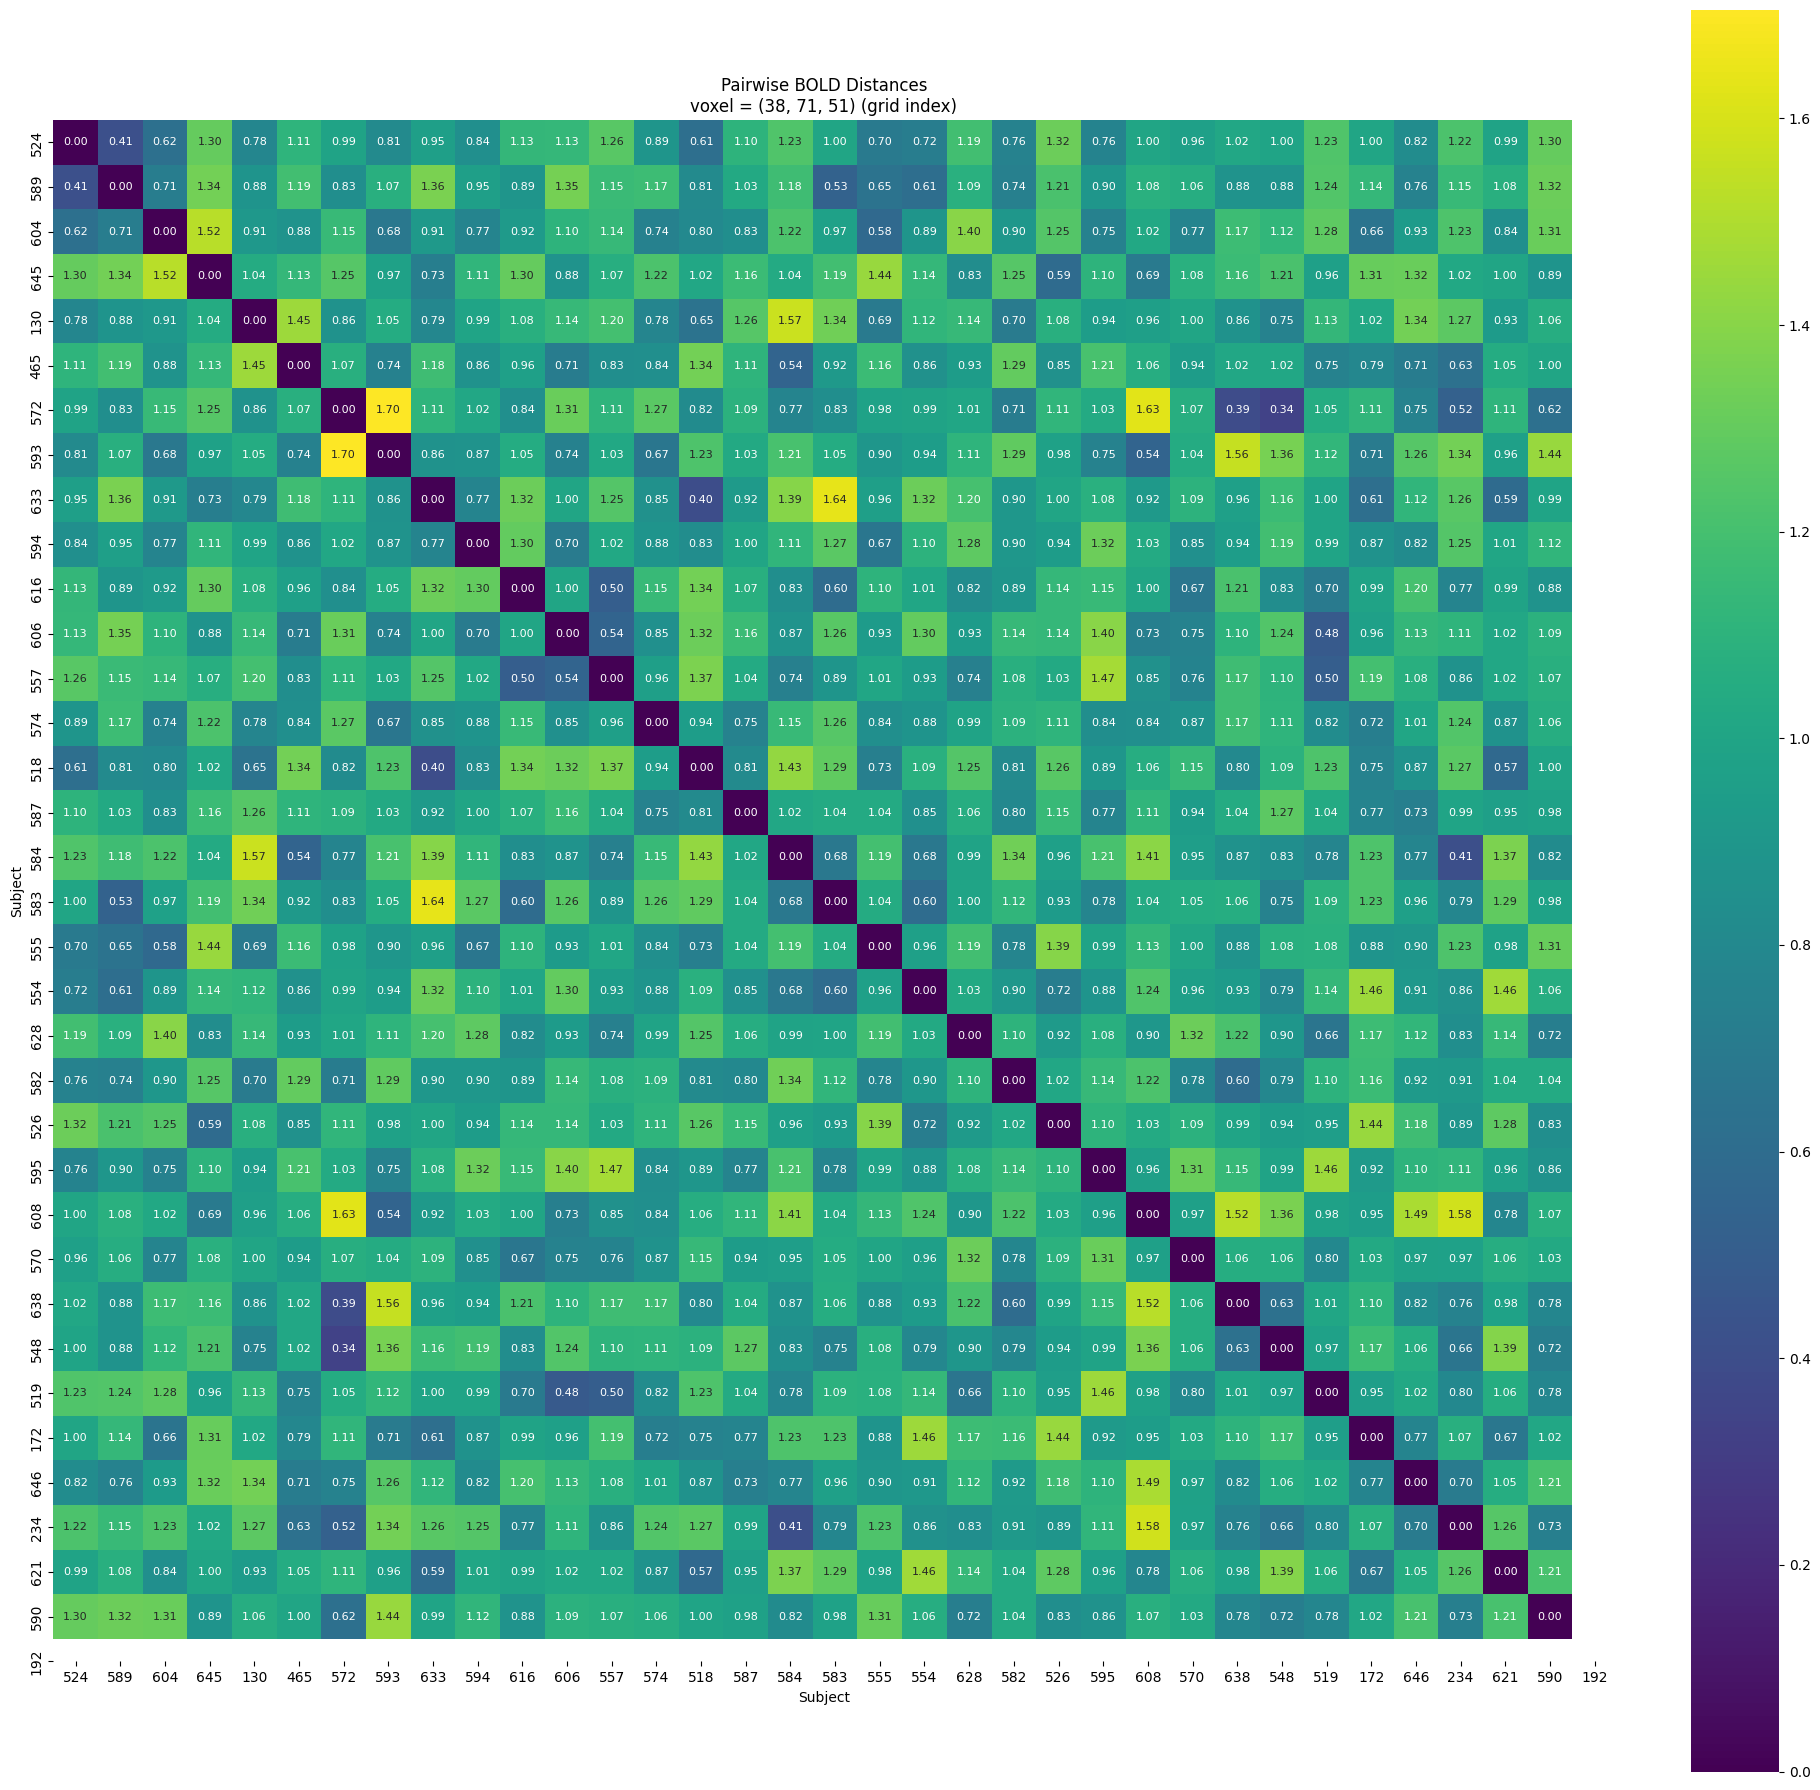

In [34]:
# Just for some randomly chosen voxels
random_values = np.random.choice(fmri_matrix.shape[2] - 1, size=5, replace=False)

for v in random_values:
    v_3d = np.column_stack(np.where(mask_3d))[v]

    bold_dist_mat1, bold_dist_vec1, rho1 = get_bold_dist_mat_plots(
        fmri_matrix, behav_dist, v, v_3d, sub_ids
    )